* MNIST - database of handwritten digits
* Boosting-Autoencoders (BAE) library
  * Creating a simple autoencoder
  * Boosted approach
* Variational Autoencoder (VAE)
* Vector Quantized Variational Autoencoder (VQ-VAE)
* Exemplar Autoencoder (EAE)

# MNIST

The MNIST database of handwritten digits, available from this [page](http://yann.lecun.com/exdb/mnist/), has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

With some classification methods (particuarly template-based methods, such as SVM and K-nearest neighbors), the error rate improves when the digits are centered by bounding box rather than center of mass. If you do this kind of pre-processing, you should report it in your publications.

The MNIST database was constructed from NIST's Special Database 3 and Special Database 1 which contain binary images of handwritten digits. NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found on the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students. Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of training set and test among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.

The MNIST training set is composed of 30,000 patterns from SD-3 and 30,000 patterns from SD-1. Our test set was composed of 5,000 patterns from SD-3 and 5,000 patterns from SD-1. The 60,000 pattern training set contained examples from approximately 250 writers. We made sure that the sets of writers of the training set and test set were disjoint.


In [ ]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(float)
X_test = X_test.astype(float)

print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train /= 255.
X_test /= 255.

11490434/11490434 [==============================] - 0s 0us/step
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


# What is a Latent Space?

A latent space is some underlying “hidden” representation for a given distribution of raw data. To clearly understand this let’s look at a simple example.

Imagine the raw data points are $x \in \mathbb{R}^n$, and they are noisily generated via a linear transform from some lower dimensional $z \in \mathbb{R}^m\; (m\lt n)$. Specifically $x$ is generated as $x=Az+v$ where $v$ is n-dimensional independent identically distributed gaussian noise and $A \in \mathbb{R}^{n\times m}$.

In general, we only get to see the raw data $x$; we do not get access to $z$, which is why it is referred to as a latent or “hidden” representation of the data. However, we would like to gain access to zz because it is a more fundamental and compressed representation for the data. Additionally, this latent representation could be a more useful input to many other algorithms that need to use the data.

This specific setup, in which the raw data is a linear transformation of the latent space, is exactly what the classical unsupervised algorithm called “PCA” is designed for: PCA essentially tries to find the underlying zz representation from the above example. This is great, but what if the latent representation had a more complicated, non-linear relationship with the raw data? For example, the figure below visualizes the kinds of high level information a more complex latent space could encode. In this case, PCA would fail to find the best latent representation. Instead we could use an autoencoder to find this more abstract latent space.

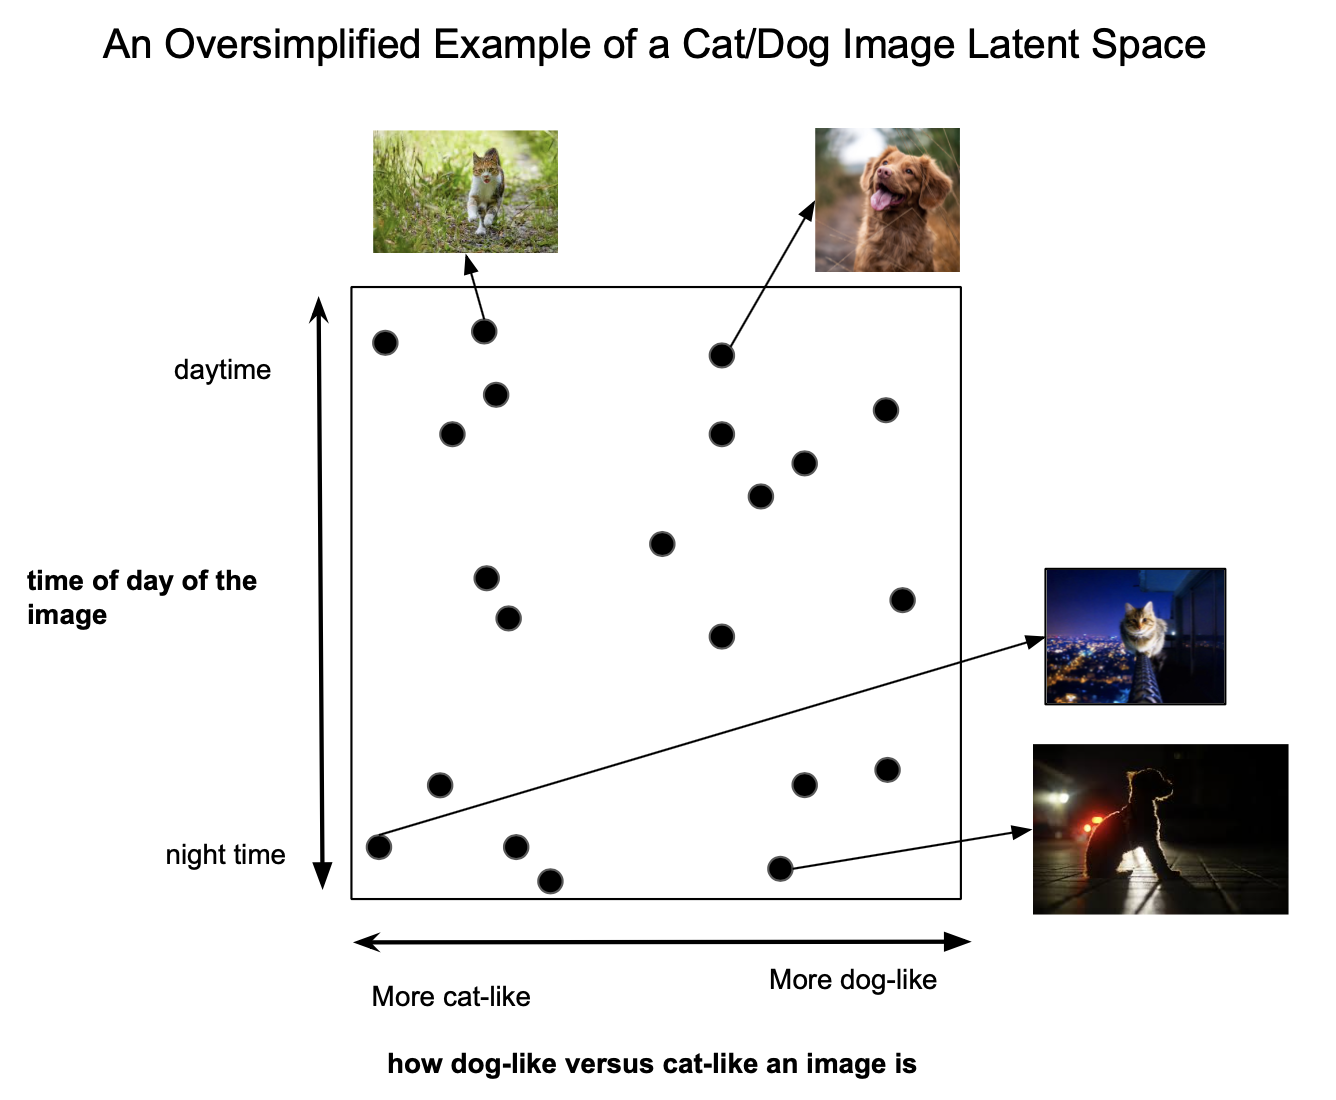

# Boosting Autoencoders (BAE)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir bae
!cd bae

mkdir: cannot create directory ‘bae’: File exists


In [ ]:
# Clone the entire repo.
!git clone https://gitlab.com/bardhp95/bae.git

fatal: destination path 'bae' already exists and is not an empty directory.


In [ ]:
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cd ..
!pwd

/content


In [ ]:
import collections

import numpy as np
import torch

import sys
sys.path.append('bae/src/')

import utils.dump as dumper
from models.fcae import FullyConnectedAE
from sampling.samplers import WeightedSampler
from utils.data import DataLoader
from stoppage.stoppers import LossValueStopper
from layer_decays.decay import LinearDecay
from torch.nn import MSELoss
from consensus.policy import combine_weighted

shrinker = LinearDecay(0.5)
bottleneck = True
learning_rate = 1e-3
weight_decay = 1e-5
threshold = 1e-4
encoder_layers = 4
loss = MSELoss()
epochs = 50
consensus = combine_weighted

stopper = LossValueStopper(threshold)

## Simple Autoencoder

In [ ]:
def get_model(enc_layers, dim):
  model = FullyConnectedAE(enc_layers, dim,\
                           shrinker, bottleneck=bottleneck)
  opt = torch.optim.Adam(model.parameters(), lr=learning_rate,\
                         amsgrad=True, weight_decay=weight_decay)
  return model, opt

In [ ]:
def reset_errors(dim):
  return np.array([0 for i in range(dim)])

In [ ]:
def get_error(model, X):
  eval_err = torch.nn.MSELoss()
  return np.array([eval_err(model(X[i]),\
                            X[i]).data.item() for i in range(X.shape[0])])

In [ ]:
def shift_losses(losses, next_loss):
    losses[0] = losses[-1]
    losses[-1] = next_loss
    return losses

### Training the model
Notice that BAE can have multiple iterations in a boosting-based fashion. However, we're only building a simple AE for now. For our scenario you can refer to the following image for an overview of an AE's architecture.

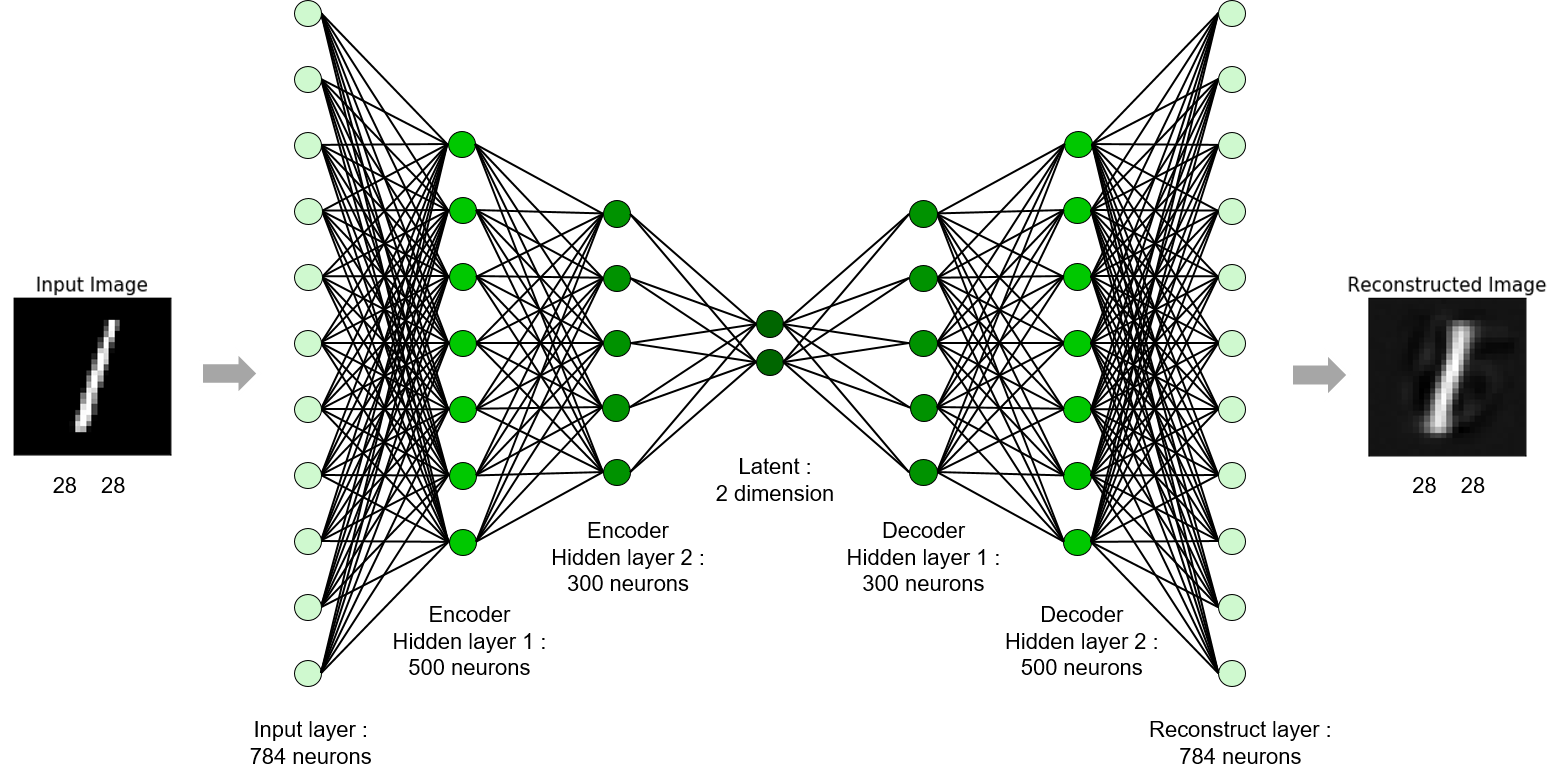

#### Preparing the MNIST data

Because our AE doesn't contain any convolutional/pooling layers, we have to flatten the image (matrix) of dimensionality $28 \times 28$ into a 784 vector that conveys the same information. Notice that this naive strategy makes the image lose structural information about the neighbouring pixels. 

In [ ]:
X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[-1])

print(f'Flattened shape for training = {X_train.shape}')
print(f'Flattened shape for testing = {X_test.shape}')

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

Flattened shape for training = (60000, 784)
Flattened shape for testing = (10000, 784)


#### Single iteration of BAE = Simple AE

In [ ]:
def train(X_train, early_stopping=True):
  # what's the number of layers when taking in input
  # the number of encoder layers?
  # it depends if we're considering a single bottleneck or not
  num_layers = encoder_layers * 2 + 1 if bottleneck else encoder_layers * 2
  print(f'Training model with {num_layers} layers...')
  # get the model with the specified number of
  # encoder layers and the data dimensionality
  model, opt = get_model(encoder_layers, X_train.shape[1])

  rec_errors = reset_errors(X_train.shape[0])

  losses = [-1,-1]
  for epoch in range(epochs):
    model.train()
    # get the reconstructed output
    X_out = model(X_train)
    # get the loss according to the MSE criterion
    l = loss(X_out, X_train)
    losses = shift_losses(losses, l)
    # zero the old gradients for the
    # backpropagation phase
    opt.zero_grad()
    # computer the backpropagation graph
    l.backward()
    # update the weights of the ADAM optimiser
    opt.step()

    print(f'Epoch {epoch + 1} - loss: {l.item()}')

    if early_stopping and stopper.stop(losses[0], losses[1], epoch):
        print(f'Loss difference {abs(losses[0]-losses[1])} < {threshold}')
        print(f'Breaking the training at epoch {epoch+1}')
        break
    
  rec_errors_train = get_error(model, X_train)
  print(f'Finished training')
  print(f'Loss: {l.item()} sum of rec_errors {np.sum(rec_errors_train)}')
  # trace the reconstruction errors for each iteration
  print(f'Reconstruction errors in training : {rec_errors_train}')
  # trace the loss
  print(f'Loss : {l.data.numpy()}')

  return model

In [ ]:
model = train(X_train)

Training model with 9 layers...
Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=392, out_features=196, bias=True)
  (3): ReLU()
  (4): Linear(in_features=196, out_features=98, bias=True)
  (5): ReLU()
  (6): Linear(in_features=98, out_features=49, bias=True)
  (7): ReLU()
  (8): Linear(in_features=49, out_features=49, bias=True)
  (9): ReLU()
  (10): Linear(in_features=49, out_features=98, bias=True)
  (11): ReLU()
  (12): Linear(in_features=98, out_features=196, bias=True)
  (13): ReLU()
  (14): Linear(in_features=196, out_features=392, bias=True)
  (15): ReLU()
  (16): Linear(in_features=392, out_features=784, bias=True)
  (17): Sigmoid()
)
Epoch 1 - loss: 0.23135001957416534
Epoch 2 - loss: 0.22947178781032562
Epoch 3 - loss: 0.2274242341518402
Epoch 4 - loss: 0.22496598958969116
Epoch 5 - loss: 0.2219032347202301
Epoch 6 - loss: 0.21798764169216156
Epoch 7 - loss: 0.21290279924869537
Epoch 8 - loss: 0.20613867044448

Notice that autoencoders don't output a simple class; rather, they try to reconstruct the input information according to a specific loss function which can be used then to calculate the so-called reconstruction loss.

However, autoencoders are generally used in anomaly detection which is a task that tries to learn from **inlier** instances and find anomalies (**outliers**) in the test set. In this scenario, the training set needs to consist of only inlier instances (say class 0 of the MNIST dataset) and the test set needs to consist of any kind of instance where those that aren't zeros should be considered as anomalous. 

According to what we stated in the previous paragraph, having a single class that describes the normality of the data distribution, we are putting ourselves in a **"Learning from Positive and Unlabelled Examples (LPUE)"** scenario [1].

[1] V. Chandola, A. Banerjee, and V. Kumar, “Outlier detection: A survey,” ACM Computing Surveys, vol. 14, p. 15, 2009.

### Showing the reconstruction of test data



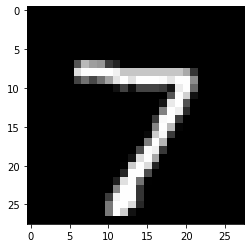

In [ ]:
from matplotlib import pyplot as plt
# show the original image
plt.imshow(X_test[0].reshape(28,28), cmap='gray')
plt.show()

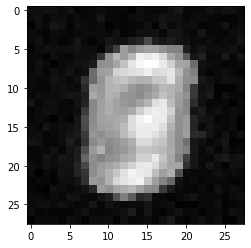

Average rec error = 0.15518128871917725


In [ ]:
# show the reconstructed image
x_test_rec = model(X_test[0])
x_test_rec = x_test_rec.reshape(28, 28).detach().numpy()
plt.imshow(x_test_rec, cmap='gray')
plt.show()

print(f'Average rec error = {np.mean(x_test_rec)}')

### Training the model for "anomaly detection"

We have to prepare the data of MNIST to consider only instances belonging to the same class (e.g., 0) in the training set.

In [ ]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(float)
X_test = X_test.astype(float)

print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train /= 255.
X_test /= 255.

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [ ]:
DESIRED_CLASS = 0

indices = np.where(y_train == DESIRED_CLASS)[0]

X_train = X_train[indices]
y_train = y_train[indices]

print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')

X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[-1])

print(f'Flattened shape for training = {X_train.shape}')
print(f'Flattened shape for testing = {X_test.shape}')

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

X_train: (5923, 28, 28)
y_train: (5923,)
Flattened shape for training = (5923, 784)
Flattened shape for testing = (10000, 784)


In [ ]:
model = train(X_train, early_stopping=False)

Training model with 9 layers...
Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=392, out_features=196, bias=True)
  (3): ReLU()
  (4): Linear(in_features=196, out_features=98, bias=True)
  (5): ReLU()
  (6): Linear(in_features=98, out_features=49, bias=True)
  (7): ReLU()
  (8): Linear(in_features=49, out_features=49, bias=True)
  (9): ReLU()
  (10): Linear(in_features=49, out_features=98, bias=True)
  (11): ReLU()
  (12): Linear(in_features=98, out_features=196, bias=True)
  (13): ReLU()
  (14): Linear(in_features=196, out_features=392, bias=True)
  (15): ReLU()
  (16): Linear(in_features=392, out_features=784, bias=True)
  (17): Sigmoid()
)
Epoch 1 - loss: 0.22754375636577606
Epoch 2 - loss: 0.2256549596786499
Epoch 3 - loss: 0.2235860824584961
Epoch 4 - loss: 0.22112582623958588
Epoch 5 - loss: 0.2180757075548172
Epoch 6 - loss: 0.21418963372707367
Epoch 7 - loss: 0.2091115266084671
Epoch 8 - loss: 0.2023715376853943

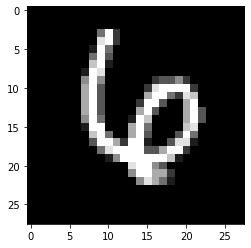

In [ ]:
from matplotlib import pyplot as plt
# show the original image
plt.imshow(X_test[np.where(y_test == 6)[0][2]].reshape(28,28), cmap='gray')
plt.show()

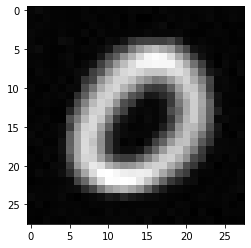

Average rec error = 0.19183434545993805


In [ ]:
# show the reconstructed image
x_test_rec = model(X_test[np.where(y_test == 6)[0][2]])
x_test_rec = x_test_rec.reshape(28, 28).detach().numpy()
plt.imshow(x_test_rec, cmap='gray')
plt.show()

print(f'Average rec error = {np.mean(x_test_rec)}')

You can clearly see that, even if the AE is trained on "normal" data, the reconstruction of the anomalies is somewhat similar to what the previous spurious model had learnt. Nevertheless, notice that the model is still able to learn the contour of where the digit is positioned. This lack of identifying correctly the normal data and learning a "normality" profile for the digit of class **DESIRED_CLASS** is due to the loss of the structural patterns that a convolutional AE might have captured better.

## Boosted version
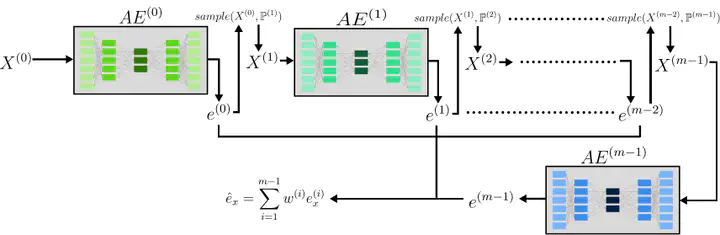

The idea behind a boosted version of the simple AE is that of becoming more specialized in learning the inlier distribution (e.g., digits of class 0) and push away in a distributional sense those instances that belong to outliers (i.e., digits of other classes). The sampling, as depicted in the Figure above, is lead by the reconstruction error in each iteration.

In [ ]:
iterations = 10

In [ ]:
def train_boosted(X_train, early_stopping=True):
  # what's the number of layers when taking in input
  # the number of encoder layers?
  # it depends if we're considering a single bottleneck or not
  sampler = WeightedSampler(X_train)
  num_layers = encoder_layers * 2 + 1 if bottleneck else encoder_layers * 2
  print(f'Training model with {num_layers} layers...')
  # get the model with the specified number of
  # encoder layers and the data dimensionality
  model, opt = get_model(encoder_layers, X_train.shape[1])
  rankings = list()
  rec_errors = reset_errors(X_train.shape[0])

  for it in range(iterations):
    # initialize the previous and current training losses
    # losses[0] -> previous loss
    # losses[1] -> current loss
    losses = [-1,-1]
    # reset the model's weights for the next AE component
    model.apply(model.weight_reset)
    # sample the virtual dataset
    X_i = sampler.sample(rec_errors, it)
    # tell torch that the virtual dataset doesn't need to
    # compute the gradients
    X_i.requires_grad_(False)

    print(f'Training component {it+1}')
    # train the components for a certain number of epochs
    for epoch in range(epochs):
      model.train()
      # get the reconstructed output of the virtual dataset
      X_i_out = model(X_i)
      # get the loss according to the MSE criterion
      l = loss(X_i_out, X_i)

      losses = shift_losses(losses, l)
      # zero the old gradients for the
      # backpropagation phase
      opt.zero_grad()
      # computer the backpropagation graph
      l.backward()
      # update the weights of the ADAM optimiser
      opt.step()

      print(f'Epoch {epoch + 1} - loss: {l.item()}')

      if early_stopping and stopper.stop(losses[0], losses[1], epoch):
          print(f'Loss difference {abs(losses[0]-losses[1])} < {threshold}')
          print(f'Breaking the training at epoch {epoch+1}')
          break
    # evaluate the reconstruction errors of the trained model
    # in the original dataset
    rec_errors = get_error(model, X_train)
    print(f'Finished training component {it+1}')
    print(f'Component {it+1}, Loss: {l.item()} sum of rec_errors {np.sum(rec_errors)}')
    
    # append the reconstruction errors in the ranking list
    # this is used to compute the consensus function
    rankings.append(rec_errors)
    # trace the reconstruction errors for each iteration
    print(f'Reconstruction errors in training : {rec_errors}')
    # trace the loss
    print(f'Loss : {l.data.numpy()}')

  final_ranking = consensus(rankings)
  print(f'Final ranking: {final_ranking}')

  print(f'Finished training BAE with a base architecture of {num_layers} layers.')
  return model

In [ ]:
boosted_model = train_boosted(X_train)

Training model with 9 layers...
Sequential(
  (0): Linear(in_features=784, out_features=392, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=392, out_features=196, bias=True)
  (3): ReLU()
  (4): Linear(in_features=196, out_features=98, bias=True)
  (5): ReLU()
  (6): Linear(in_features=98, out_features=49, bias=True)
  (7): ReLU()
  (8): Linear(in_features=49, out_features=49, bias=True)
  (9): ReLU()
  (10): Linear(in_features=49, out_features=98, bias=True)
  (11): ReLU()
  (12): Linear(in_features=98, out_features=196, bias=True)
  (13): ReLU()
  (14): Linear(in_features=196, out_features=392, bias=True)
  (15): ReLU()
  (16): Linear(in_features=392, out_features=784, bias=True)
  (17): Sigmoid()
)
Training component 1
Epoch 1 - loss: 0.2276582419872284
Epoch 2 - loss: 0.22564151883125305
Epoch 3 - loss: 0.22344659268856049
Epoch 4 - loss: 0.2208002358675003
Epoch 5 - loss: 0.2175230085849762
Epoch 6 - loss: 0.21330924332141876
Epoch 7 - loss: 0.20771726965904236
Epoch 8 - lo

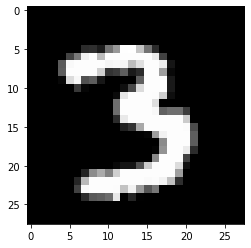

In [ ]:
from matplotlib import pyplot as plt
# show the original image
plt.imshow(X_test[500].reshape(28,28), cmap='gray')
plt.show()

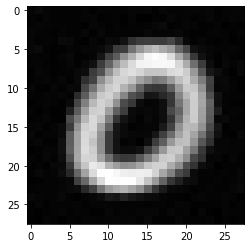

Avg rec error = 0.1880967617034912


In [ ]:
# show the reconstructed image
x_test_rec = model(X_test[500])
x_test_rec = x_test_rec.reshape(28, 28).detach().numpy()
plt.imshow(x_test_rec, cmap='gray')
plt.show()

print(f'Avg rec error = {np.mean(x_test_rec)}')

# Variational Autoencoder (VAE)

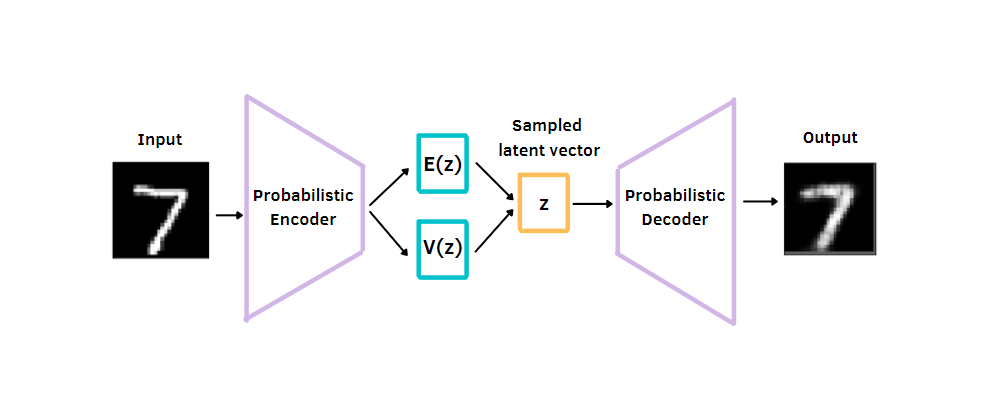

The standard autoencoder can have an issue, constituted by the fact that the latent space can be irregular. This means that close points in the latent space can produce different and meaningless patterns over visible units.

One solution to this issue is the introduction of the Variational Autoencoder. As the autoencoder, it is composed of two neural network architectures, encoder, and decoder.

But there is a modification of the encoding-decoding process. I will explain all the steps:


*   We encode the input as a distribution over the latent space, instead of considering it as a single point. This encoded distribution is chosen to be normal so that the encoder can be trained to return the mean matrix and the covariance matrix.
*   In the second step, we sample a point from that encoded distribution.
*  After, we can decode the sampled point and calculate the reconstruction error
*  We backpropagate the reconstruction error through the network. Since the sampling procedure is a discrete process, so it’s not continuous, we need to apply a reparameterisation trick to make the backpropagation work:

$z = \mathbb{E}(z) + \epsilon \cdot \sqrt{V(z)}$ where $\epsilon \sim \mathcal{N}(0,\mathbb{I}_d)$.



### VAE Loss function

The loss for the VAE consists of two terms:

*  the first term is the reconstruction term, which is obtained by comparing the input and its corresponding reconstruction.
* An additional term is the regularization term, which is also called Kullback-Leibler (KL) divergence between the distribution returned by the encoder and the standard normal distribution. This term acts as a regularizer in the latent space, making the distributions returned by the encoder close to a standard normal distribution.

$\mathcal{L}(x,\hat{x}) = \mathcal{L}_{\text{rec_error}} + \text{KL}(z,\mathcal{N}(0,\mathbb{I}_d))$

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
data_dir = 'dataset'
device = 'gpu' if torch.cuda.is_available() else 'cpu'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
  transforms.ToTensor(),
  ])

test_transform = transforms.Compose([
  transforms.ToTensor(),
  ])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

Now, we define a VariationalAutoencoder class, which combines the Encoder and Decoder classes.

The encoder and decoder networks contain three convolutional layers and two fully connected layers. Some batch normal layers are added to have more robust features in the latent space. Differently from the standard autoencoder, the encoder returns mean and variance matrices and we use them to obtain the sampled latent vector. In the VariationalEncoder class, we obtain the Kullback-Leibler term.

In [ ]:
class VariationalEncoder(nn.Module):

  def __init__(self, latent_dims):
    super(VariationalEncoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)
    self.batch2 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0)
    self.linear1 = nn.Linear(3*3*32, 128)
    self.linear2 = nn.Linear(128, latent_dims)
    self.linear3 = nn.Linear(128, latent_dims)

    self.N = torch.distributions.normal.Normal(0,1)
    self.N.loc = self.N.loc.cuda() # get sampling on the GPU
    self.N.scale = self.N.scale.cuda()
    self.kl = 0

  def forward(self, x):
    x = x.to(device)
    x = F.relu(self.conv1(x))
    x = F.relu(self.batch2(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.linear1(x))
    mu = self.linear2(x)
    sigma = torch.exp(self.linear3(x))
    z = mu + sigma * self.N.sample(mu.shape)
    self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
    return z

After we define the Decoder class.



In [ ]:
class Decoder(nn.Module):

  def __init__(self, latent_dims):
    super().__init__()

    self.decoder_lin = nn.Sequential(
        nn.Linear(latent_dims, 128),
        nn.ReLU(True),
        nn.Linear(128, 3*3*32),
        nn.ReLU(True)
    )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32,3,3))
    
    self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
    )

  def forward(self, x):
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)
    return x

Below, we define the class that merges the encoder and decoder

In [ ]:
class VariationalAutoencoder(nn.Module):
  
  def __init__(self, latent_dims):
    super(VariationalAutoencoder, self).__init__()
    self.encoder = VariationalEncoder(latent_dims)
    self.decoder = Decoder(latent_dims)

  def forward(self, x):
    x = x.to(device)
    z = self.encoder(x)
    return self.decoder(z)

Finally, we can initialize the VariationalAutoencoder class, the optimizer, and the device to use the GPU in the code.


In [ ]:
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(d)

lr = 1e-3

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

vae.to(device)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

### Training and evaluation of VAE
We define the functions to train and evaluate the Variational Autoencoder:


In [ ]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
  # Set train mode for both the encoder and the decoder
  vae.train()
  train_loss = 0.0
  # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
  for x, _ in dataloader: 
    # Move tensor to the proper device
    x = x.to(device)
    x_hat = vae(x)
    # Evaluate loss
    loss = ((x - x_hat)**2).sum() + vae.encoder.kl

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Print batch loss
    print('\t partial train loss (single batch): %f' % (loss.item()))
    train_loss+=loss.item()

  return train_loss / len(dataloader.dataset)

The loss is composed of two terms, as I described in the theory above. The reconstruction term is the sum of the squared differences between the input and its reconstruction. Some other versions use the BCE loss instead of MSE loss.



In [ ]:
### Testing function
def test_epoch(vae, device, dataloader):
  # Set evaluation mode for encoder and decoder
  vae.eval()
  val_loss = 0.0
  with torch.no_grad(): # No need to track the gradients
    for x, _ in dataloader:
      # Move tensor to the proper device
      x = x.to(device)
      # Encode data
      encoded_data = vae.encoder(x)
      # Decode data
      x_hat = vae(x)
      loss = ((x - x_hat)**2).sum() + vae.encoder.kl
      val_loss += loss.item()

  return val_loss / len(dataloader.dataset)

In [ ]:
import math

def plot_ae_outputs(encoder, decoder, n=10):
  targets = test_dataset.targets.numpy()
  t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
  plt.figure(figsize=(n*4,n*4))
  figure, axis = plt.subplots(2, n)
  for i in range(n):
    img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
      rec_img = decoder(encoder(img))
    axis[0,i].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axis[0,i].set_title('Org.')
    axis[0,i].axis("off")
    axis[1,i].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axis[1,i].set_title('Rec.')
    axis[1,i].axis("off")
   
  plt.show()

It’s time to finally train the VAE and evaluate in the validation set:



	 partial train loss (single batch): 9221.903320
	 partial train loss (single batch): 9106.714844
	 partial train loss (single batch): 8558.242188
	 partial train loss (single batch): 8979.131836
	 partial train loss (single batch): 9078.105469
	 partial train loss (single batch): 8817.294922
	 partial train loss (single batch): 8710.706055
	 partial train loss (single batch): 8898.939453
	 partial train loss (single batch): 8871.501953
	 partial train loss (single batch): 8724.128906
	 partial train loss (single batch): 9054.319336
	 partial train loss (single batch): 8962.631836
	 partial train loss (single batch): 8725.472656
	 partial train loss (single batch): 8809.908203
	 partial train loss (single batch): 8703.628906
	 partial train loss (single batch): 8824.269531
	 partial train loss (single batch): 8851.314453
	 partial train loss (single batch): 8457.947266
	 partial train loss (single batch): 8774.412109
	 partial train loss (single batch): 8945.912109
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

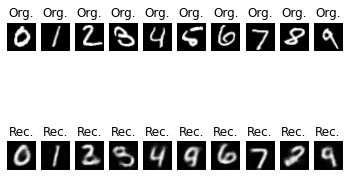

	 partial train loss (single batch): 9216.707031
	 partial train loss (single batch): 8977.066406
	 partial train loss (single batch): 8565.019531
	 partial train loss (single batch): 8825.603516
	 partial train loss (single batch): 9023.417969
	 partial train loss (single batch): 8864.197266
	 partial train loss (single batch): 8603.630859
	 partial train loss (single batch): 8807.485352
	 partial train loss (single batch): 8885.734375
	 partial train loss (single batch): 8712.189453
	 partial train loss (single batch): 8966.959961
	 partial train loss (single batch): 8891.384766
	 partial train loss (single batch): 8730.916016
	 partial train loss (single batch): 8806.914062
	 partial train loss (single batch): 8612.675781
	 partial train loss (single batch): 8769.985352
	 partial train loss (single batch): 8830.246094
	 partial train loss (single batch): 8307.916016
	 partial train loss (single batch): 8660.295898
	 partial train loss (single batch): 8984.056641
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

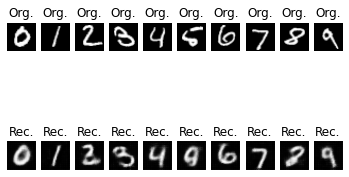

	 partial train loss (single batch): 9214.151367
	 partial train loss (single batch): 8968.391602
	 partial train loss (single batch): 8548.384766
	 partial train loss (single batch): 8744.349609
	 partial train loss (single batch): 8948.259766
	 partial train loss (single batch): 8727.351562
	 partial train loss (single batch): 8559.867188
	 partial train loss (single batch): 8739.271484
	 partial train loss (single batch): 8791.093750
	 partial train loss (single batch): 8748.371094
	 partial train loss (single batch): 8935.195312
	 partial train loss (single batch): 8909.656250
	 partial train loss (single batch): 8664.109375
	 partial train loss (single batch): 8781.425781
	 partial train loss (single batch): 8590.068359
	 partial train loss (single batch): 8684.614258
	 partial train loss (single batch): 8748.265625
	 partial train loss (single batch): 8335.263672
	 partial train loss (single batch): 8681.540039
	 partial train loss (single batch): 8928.841797
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

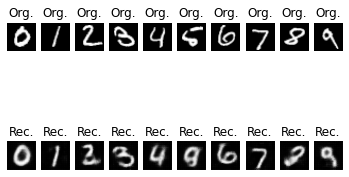

	 partial train loss (single batch): 9013.213867
	 partial train loss (single batch): 8872.089844
	 partial train loss (single batch): 8399.848633
	 partial train loss (single batch): 8709.859375
	 partial train loss (single batch): 8815.217773
	 partial train loss (single batch): 8734.311523
	 partial train loss (single batch): 8572.781250
	 partial train loss (single batch): 8694.909180
	 partial train loss (single batch): 8769.712891
	 partial train loss (single batch): 8665.935547
	 partial train loss (single batch): 8889.935547
	 partial train loss (single batch): 8810.875000
	 partial train loss (single batch): 8560.850586
	 partial train loss (single batch): 8672.005859
	 partial train loss (single batch): 8508.502930
	 partial train loss (single batch): 8686.801758
	 partial train loss (single batch): 8688.332031
	 partial train loss (single batch): 8230.591797
	 partial train loss (single batch): 8640.313477
	 partial train loss (single batch): 8923.143555
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

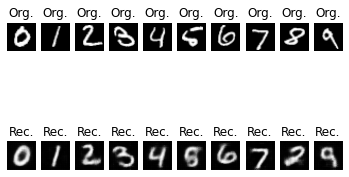

	 partial train loss (single batch): 8998.545898
	 partial train loss (single batch): 8853.235352
	 partial train loss (single batch): 8431.750000
	 partial train loss (single batch): 8660.285156
	 partial train loss (single batch): 8864.554688
	 partial train loss (single batch): 8685.255859
	 partial train loss (single batch): 8478.194336
	 partial train loss (single batch): 8597.658203
	 partial train loss (single batch): 8728.152344
	 partial train loss (single batch): 8520.189453
	 partial train loss (single batch): 8777.257812
	 partial train loss (single batch): 8765.358398
	 partial train loss (single batch): 8578.516602
	 partial train loss (single batch): 8618.067383
	 partial train loss (single batch): 8436.902344
	 partial train loss (single batch): 8606.993164
	 partial train loss (single batch): 8658.994141
	 partial train loss (single batch): 8208.917969
	 partial train loss (single batch): 8534.052734
	 partial train loss (single batch): 8803.076172
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

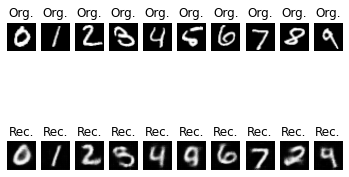

	 partial train loss (single batch): 8992.613281
	 partial train loss (single batch): 8797.437500
	 partial train loss (single batch): 8419.386719
	 partial train loss (single batch): 8702.057617
	 partial train loss (single batch): 8826.641602
	 partial train loss (single batch): 8640.099609
	 partial train loss (single batch): 8440.687500
	 partial train loss (single batch): 8556.675781
	 partial train loss (single batch): 8718.978516
	 partial train loss (single batch): 8506.046875
	 partial train loss (single batch): 8726.791016
	 partial train loss (single batch): 8757.315430
	 partial train loss (single batch): 8488.810547
	 partial train loss (single batch): 8653.834961
	 partial train loss (single batch): 8527.816406
	 partial train loss (single batch): 8593.255859
	 partial train loss (single batch): 8565.847656
	 partial train loss (single batch): 8172.991699
	 partial train loss (single batch): 8547.331055
	 partial train loss (single batch): 8801.066406
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

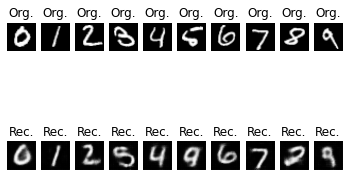

	 partial train loss (single batch): 8924.958008
	 partial train loss (single batch): 8786.017578
	 partial train loss (single batch): 8297.794922
	 partial train loss (single batch): 8564.636719
	 partial train loss (single batch): 8807.908203
	 partial train loss (single batch): 8604.087891
	 partial train loss (single batch): 8417.632812
	 partial train loss (single batch): 8632.187500
	 partial train loss (single batch): 8738.579102
	 partial train loss (single batch): 8535.399414
	 partial train loss (single batch): 8688.690430
	 partial train loss (single batch): 8752.093750
	 partial train loss (single batch): 8505.551758
	 partial train loss (single batch): 8620.564453
	 partial train loss (single batch): 8440.355469
	 partial train loss (single batch): 8610.954102
	 partial train loss (single batch): 8614.347656
	 partial train loss (single batch): 8183.339355
	 partial train loss (single batch): 8467.089844
	 partial train loss (single batch): 8753.033203
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

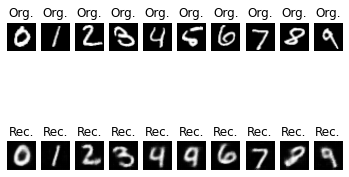

	 partial train loss (single batch): 8888.438477
	 partial train loss (single batch): 8752.781250
	 partial train loss (single batch): 8355.712891
	 partial train loss (single batch): 8564.723633
	 partial train loss (single batch): 8722.201172
	 partial train loss (single batch): 8619.741211
	 partial train loss (single batch): 8338.263672
	 partial train loss (single batch): 8482.166016
	 partial train loss (single batch): 8640.057617
	 partial train loss (single batch): 8508.458984
	 partial train loss (single batch): 8677.036133
	 partial train loss (single batch): 8720.836914
	 partial train loss (single batch): 8485.452148
	 partial train loss (single batch): 8519.497070
	 partial train loss (single batch): 8413.267578
	 partial train loss (single batch): 8548.736328
	 partial train loss (single batch): 8594.135742
	 partial train loss (single batch): 8173.703125
	 partial train loss (single batch): 8354.969727
	 partial train loss (single batch): 8717.560547
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

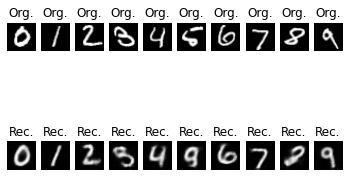

	 partial train loss (single batch): 8835.502930
	 partial train loss (single batch): 8753.768555
	 partial train loss (single batch): 8358.390625
	 partial train loss (single batch): 8583.218750
	 partial train loss (single batch): 8746.898438
	 partial train loss (single batch): 8615.392578
	 partial train loss (single batch): 8324.106445
	 partial train loss (single batch): 8575.264648
	 partial train loss (single batch): 8639.700195
	 partial train loss (single batch): 8462.349609
	 partial train loss (single batch): 8657.883789
	 partial train loss (single batch): 8663.990234
	 partial train loss (single batch): 8552.499023
	 partial train loss (single batch): 8491.969727
	 partial train loss (single batch): 8400.631836
	 partial train loss (single batch): 8450.912109
	 partial train loss (single batch): 8570.142578
	 partial train loss (single batch): 8081.671387
	 partial train loss (single batch): 8483.126953
	 partial train loss (single batch): 8744.948242
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

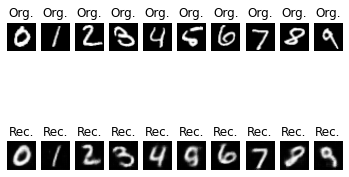

	 partial train loss (single batch): 8880.221680
	 partial train loss (single batch): 8714.926758
	 partial train loss (single batch): 8239.582031
	 partial train loss (single batch): 8598.134766
	 partial train loss (single batch): 8734.445312
	 partial train loss (single batch): 8540.320312
	 partial train loss (single batch): 8327.619141
	 partial train loss (single batch): 8534.535156
	 partial train loss (single batch): 8712.324219
	 partial train loss (single batch): 8462.775391
	 partial train loss (single batch): 8623.796875
	 partial train loss (single batch): 8681.795898
	 partial train loss (single batch): 8432.127930
	 partial train loss (single batch): 8566.045898
	 partial train loss (single batch): 8308.708984
	 partial train loss (single batch): 8495.382812
	 partial train loss (single batch): 8493.701172
	 partial train loss (single batch): 8068.110352
	 partial train loss (single batch): 8410.212891
	 partial train loss (single batch): 8617.587891
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

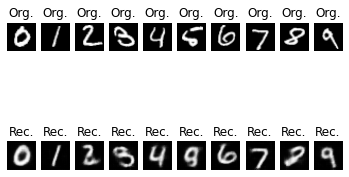

	 partial train loss (single batch): 8831.297852
	 partial train loss (single batch): 8736.598633
	 partial train loss (single batch): 8279.446289
	 partial train loss (single batch): 8471.691406
	 partial train loss (single batch): 8622.361328
	 partial train loss (single batch): 8534.180664
	 partial train loss (single batch): 8327.102539
	 partial train loss (single batch): 8426.011719
	 partial train loss (single batch): 8621.571289
	 partial train loss (single batch): 8433.300781
	 partial train loss (single batch): 8697.242188
	 partial train loss (single batch): 8657.996094
	 partial train loss (single batch): 8444.357422
	 partial train loss (single batch): 8530.533203
	 partial train loss (single batch): 8311.126953
	 partial train loss (single batch): 8361.507812
	 partial train loss (single batch): 8587.843750
	 partial train loss (single batch): 8102.204590
	 partial train loss (single batch): 8396.607422
	 partial train loss (single batch): 8695.692383
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

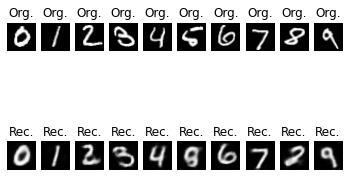

	 partial train loss (single batch): 8821.559570
	 partial train loss (single batch): 8713.296875
	 partial train loss (single batch): 8274.535156
	 partial train loss (single batch): 8508.178711
	 partial train loss (single batch): 8650.494141
	 partial train loss (single batch): 8510.595703
	 partial train loss (single batch): 8339.453125
	 partial train loss (single batch): 8362.890625
	 partial train loss (single batch): 8622.066406
	 partial train loss (single batch): 8402.899414
	 partial train loss (single batch): 8602.593750
	 partial train loss (single batch): 8580.516602
	 partial train loss (single batch): 8371.343750
	 partial train loss (single batch): 8503.484375
	 partial train loss (single batch): 8356.256836
	 partial train loss (single batch): 8362.585938
	 partial train loss (single batch): 8453.355469
	 partial train loss (single batch): 8088.027832
	 partial train loss (single batch): 8336.263672
	 partial train loss (single batch): 8681.203125
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

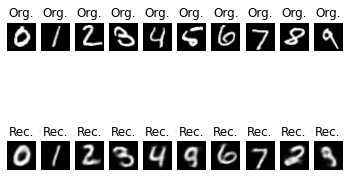

	 partial train loss (single batch): 8783.350586
	 partial train loss (single batch): 8761.351562
	 partial train loss (single batch): 8209.708008
	 partial train loss (single batch): 8473.093750
	 partial train loss (single batch): 8645.368164
	 partial train loss (single batch): 8473.505859
	 partial train loss (single batch): 8254.433594
	 partial train loss (single batch): 8488.019531
	 partial train loss (single batch): 8602.528320
	 partial train loss (single batch): 8377.839844
	 partial train loss (single batch): 8653.174805
	 partial train loss (single batch): 8517.986328
	 partial train loss (single batch): 8361.949219
	 partial train loss (single batch): 8542.074219
	 partial train loss (single batch): 8276.535156
	 partial train loss (single batch): 8440.021484
	 partial train loss (single batch): 8498.467773
	 partial train loss (single batch): 8085.599121
	 partial train loss (single batch): 8306.832031
	 partial train loss (single batch): 8582.183594
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

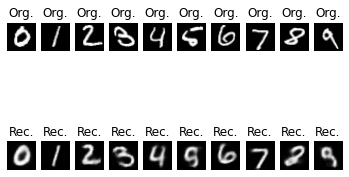

	 partial train loss (single batch): 8779.839844
	 partial train loss (single batch): 8624.790039
	 partial train loss (single batch): 8192.809570
	 partial train loss (single batch): 8427.988281
	 partial train loss (single batch): 8604.845703
	 partial train loss (single batch): 8504.445312
	 partial train loss (single batch): 8285.404297
	 partial train loss (single batch): 8449.166016
	 partial train loss (single batch): 8505.914062
	 partial train loss (single batch): 8349.386719
	 partial train loss (single batch): 8570.533203
	 partial train loss (single batch): 8578.432617
	 partial train loss (single batch): 8343.882812
	 partial train loss (single batch): 8476.630859
	 partial train loss (single batch): 8327.055664
	 partial train loss (single batch): 8368.410156
	 partial train loss (single batch): 8499.544922
	 partial train loss (single batch): 8089.923340
	 partial train loss (single batch): 8394.410156
	 partial train loss (single batch): 8633.940430
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

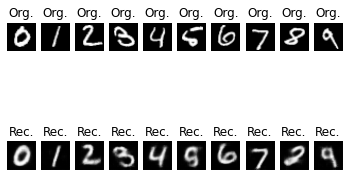

	 partial train loss (single batch): 8719.046875
	 partial train loss (single batch): 8654.496094
	 partial train loss (single batch): 8297.277344
	 partial train loss (single batch): 8382.861328
	 partial train loss (single batch): 8528.412109
	 partial train loss (single batch): 8516.010742
	 partial train loss (single batch): 8227.402344
	 partial train loss (single batch): 8348.654297
	 partial train loss (single batch): 8483.601562
	 partial train loss (single batch): 8357.902344
	 partial train loss (single batch): 8571.151367
	 partial train loss (single batch): 8564.025391
	 partial train loss (single batch): 8294.808594
	 partial train loss (single batch): 8522.586914
	 partial train loss (single batch): 8370.417969
	 partial train loss (single batch): 8328.435547
	 partial train loss (single batch): 8459.366211
	 partial train loss (single batch): 8082.963867
	 partial train loss (single batch): 8325.926758
	 partial train loss (single batch): 8552.929688
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

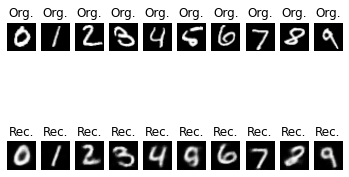

	 partial train loss (single batch): 8692.329102
	 partial train loss (single batch): 8662.605469
	 partial train loss (single batch): 8135.783691
	 partial train loss (single batch): 8369.773438
	 partial train loss (single batch): 8527.773438
	 partial train loss (single batch): 8472.651367
	 partial train loss (single batch): 8220.519531
	 partial train loss (single batch): 8403.244141
	 partial train loss (single batch): 8572.052734
	 partial train loss (single batch): 8369.392578
	 partial train loss (single batch): 8570.455078
	 partial train loss (single batch): 8573.451172
	 partial train loss (single batch): 8391.193359
	 partial train loss (single batch): 8443.251953
	 partial train loss (single batch): 8272.587891
	 partial train loss (single batch): 8389.852539
	 partial train loss (single batch): 8457.470703
	 partial train loss (single batch): 8019.593750
	 partial train loss (single batch): 8243.712891
	 partial train loss (single batch): 8590.156250
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

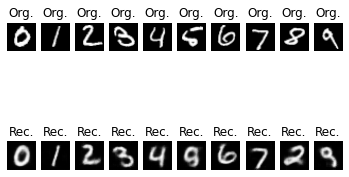

	 partial train loss (single batch): 8681.564453
	 partial train loss (single batch): 8666.468750
	 partial train loss (single batch): 8236.035156
	 partial train loss (single batch): 8336.794922
	 partial train loss (single batch): 8537.818359
	 partial train loss (single batch): 8402.858398
	 partial train loss (single batch): 8215.615234
	 partial train loss (single batch): 8355.623047
	 partial train loss (single batch): 8506.302734
	 partial train loss (single batch): 8407.878906
	 partial train loss (single batch): 8487.626953
	 partial train loss (single batch): 8567.656250
	 partial train loss (single batch): 8261.183594
	 partial train loss (single batch): 8420.818359
	 partial train loss (single batch): 8364.741211
	 partial train loss (single batch): 8326.644531
	 partial train loss (single batch): 8419.792969
	 partial train loss (single batch): 7940.660156
	 partial train loss (single batch): 8295.037109
	 partial train loss (single batch): 8620.093750
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

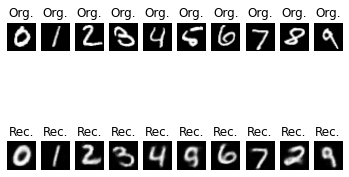

	 partial train loss (single batch): 8645.097656
	 partial train loss (single batch): 8639.466797
	 partial train loss (single batch): 8176.923828
	 partial train loss (single batch): 8361.792969
	 partial train loss (single batch): 8601.376953
	 partial train loss (single batch): 8455.425781
	 partial train loss (single batch): 8182.413086
	 partial train loss (single batch): 8412.640625
	 partial train loss (single batch): 8563.799805
	 partial train loss (single batch): 8328.833008
	 partial train loss (single batch): 8468.385742
	 partial train loss (single batch): 8496.220703
	 partial train loss (single batch): 8257.214844
	 partial train loss (single batch): 8442.779297
	 partial train loss (single batch): 8181.278320
	 partial train loss (single batch): 8369.339844
	 partial train loss (single batch): 8413.415039
	 partial train loss (single batch): 8082.225098
	 partial train loss (single batch): 8237.508789
	 partial train loss (single batch): 8577.535156
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

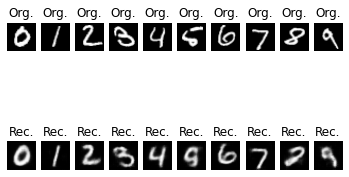

	 partial train loss (single batch): 8629.206055
	 partial train loss (single batch): 8528.687500
	 partial train loss (single batch): 8116.797852
	 partial train loss (single batch): 8324.371094
	 partial train loss (single batch): 8522.994141
	 partial train loss (single batch): 8346.726562
	 partial train loss (single batch): 8180.386230
	 partial train loss (single batch): 8313.961914
	 partial train loss (single batch): 8425.732422
	 partial train loss (single batch): 8361.009766
	 partial train loss (single batch): 8464.011719
	 partial train loss (single batch): 8471.842773
	 partial train loss (single batch): 8292.683594
	 partial train loss (single batch): 8357.529297
	 partial train loss (single batch): 8219.964844
	 partial train loss (single batch): 8266.417969
	 partial train loss (single batch): 8367.128906
	 partial train loss (single batch): 7948.612793
	 partial train loss (single batch): 8256.050781
	 partial train loss (single batch): 8561.595703
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

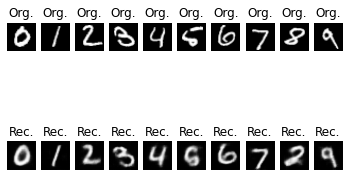

	 partial train loss (single batch): 8625.638672
	 partial train loss (single batch): 8531.890625
	 partial train loss (single batch): 8213.365234
	 partial train loss (single batch): 8300.219727
	 partial train loss (single batch): 8412.442383
	 partial train loss (single batch): 8411.836914
	 partial train loss (single batch): 8234.675781
	 partial train loss (single batch): 8284.001953
	 partial train loss (single batch): 8446.107422
	 partial train loss (single batch): 8310.703125
	 partial train loss (single batch): 8513.302734
	 partial train loss (single batch): 8456.930664
	 partial train loss (single batch): 8275.664062
	 partial train loss (single batch): 8378.598633
	 partial train loss (single batch): 8216.416016
	 partial train loss (single batch): 8291.111328
	 partial train loss (single batch): 8418.175781
	 partial train loss (single batch): 7939.421387
	 partial train loss (single batch): 8259.533203
	 partial train loss (single batch): 8494.210938
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

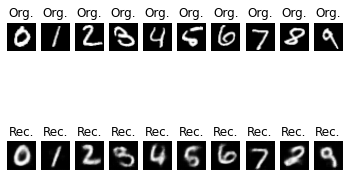

	 partial train loss (single batch): 8650.603516
	 partial train loss (single batch): 8550.116211
	 partial train loss (single batch): 8141.889648
	 partial train loss (single batch): 8269.319336
	 partial train loss (single batch): 8534.481445
	 partial train loss (single batch): 8338.021484
	 partial train loss (single batch): 8186.087402
	 partial train loss (single batch): 8371.808594
	 partial train loss (single batch): 8427.197266
	 partial train loss (single batch): 8326.163086
	 partial train loss (single batch): 8514.757812
	 partial train loss (single batch): 8485.756836
	 partial train loss (single batch): 8230.240234
	 partial train loss (single batch): 8363.009766
	 partial train loss (single batch): 8131.170410
	 partial train loss (single batch): 8309.878906
	 partial train loss (single batch): 8480.581055
	 partial train loss (single batch): 8003.304688
	 partial train loss (single batch): 8264.888672
	 partial train loss (single batch): 8540.483398
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

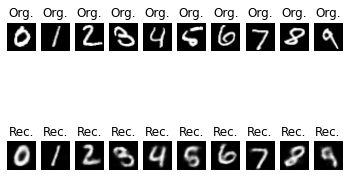

	 partial train loss (single batch): 8612.910156
	 partial train loss (single batch): 8511.410156
	 partial train loss (single batch): 8107.958984
	 partial train loss (single batch): 8250.760742
	 partial train loss (single batch): 8451.339844
	 partial train loss (single batch): 8342.519531
	 partial train loss (single batch): 8223.375000
	 partial train loss (single batch): 8335.023438
	 partial train loss (single batch): 8375.286133
	 partial train loss (single batch): 8269.800781
	 partial train loss (single batch): 8494.349609
	 partial train loss (single batch): 8457.390625
	 partial train loss (single batch): 8305.005859
	 partial train loss (single batch): 8406.030273
	 partial train loss (single batch): 8153.959961
	 partial train loss (single batch): 8240.578125
	 partial train loss (single batch): 8402.141602
	 partial train loss (single batch): 7917.083984
	 partial train loss (single batch): 8245.034180
	 partial train loss (single batch): 8511.845703
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

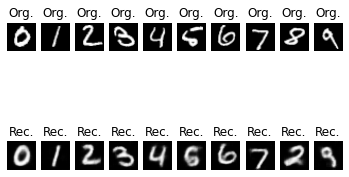

	 partial train loss (single batch): 8636.980469
	 partial train loss (single batch): 8576.355469
	 partial train loss (single batch): 8096.348145
	 partial train loss (single batch): 8290.634766
	 partial train loss (single batch): 8493.603516
	 partial train loss (single batch): 8306.624023
	 partial train loss (single batch): 8164.951172
	 partial train loss (single batch): 8295.424805
	 partial train loss (single batch): 8443.687500
	 partial train loss (single batch): 8277.779297
	 partial train loss (single batch): 8476.046875
	 partial train loss (single batch): 8444.177734
	 partial train loss (single batch): 8254.666992
	 partial train loss (single batch): 8349.938477
	 partial train loss (single batch): 8157.041504
	 partial train loss (single batch): 8341.692383
	 partial train loss (single batch): 8421.778320
	 partial train loss (single batch): 7934.031738
	 partial train loss (single batch): 8171.862305
	 partial train loss (single batch): 8457.398438
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

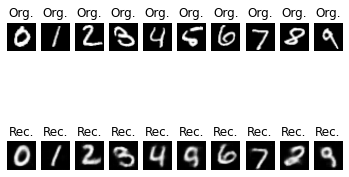

	 partial train loss (single batch): 8640.333984
	 partial train loss (single batch): 8540.557617
	 partial train loss (single batch): 8024.525391
	 partial train loss (single batch): 8269.539062
	 partial train loss (single batch): 8480.156250
	 partial train loss (single batch): 8297.947266
	 partial train loss (single batch): 8146.808594
	 partial train loss (single batch): 8305.669922
	 partial train loss (single batch): 8374.442383
	 partial train loss (single batch): 8299.826172
	 partial train loss (single batch): 8431.153320
	 partial train loss (single batch): 8371.878906
	 partial train loss (single batch): 8149.011719
	 partial train loss (single batch): 8466.831055
	 partial train loss (single batch): 8172.630859
	 partial train loss (single batch): 8213.514648
	 partial train loss (single batch): 8431.320312
	 partial train loss (single batch): 7939.087402
	 partial train loss (single batch): 8240.358398
	 partial train loss (single batch): 8443.510742
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

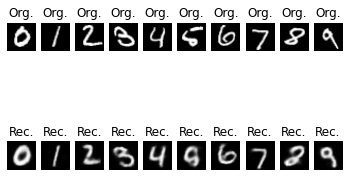

	 partial train loss (single batch): 8492.841797
	 partial train loss (single batch): 8540.126953
	 partial train loss (single batch): 8148.909668
	 partial train loss (single batch): 8268.375000
	 partial train loss (single batch): 8551.525391
	 partial train loss (single batch): 8330.350586
	 partial train loss (single batch): 8088.562012
	 partial train loss (single batch): 8241.078125
	 partial train loss (single batch): 8466.522461
	 partial train loss (single batch): 8242.490234
	 partial train loss (single batch): 8421.836914
	 partial train loss (single batch): 8393.397461
	 partial train loss (single batch): 8242.923828
	 partial train loss (single batch): 8355.707031
	 partial train loss (single batch): 8084.912598
	 partial train loss (single batch): 8212.845703
	 partial train loss (single batch): 8395.923828
	 partial train loss (single batch): 7916.768555
	 partial train loss (single batch): 8172.268555
	 partial train loss (single batch): 8488.504883
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

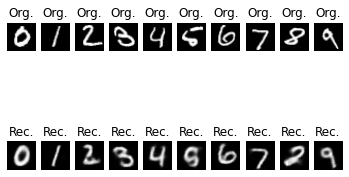

	 partial train loss (single batch): 8579.014648
	 partial train loss (single batch): 8540.724609
	 partial train loss (single batch): 8080.177734
	 partial train loss (single batch): 8242.764648
	 partial train loss (single batch): 8461.068359
	 partial train loss (single batch): 8256.639648
	 partial train loss (single batch): 8151.211426
	 partial train loss (single batch): 8301.922852
	 partial train loss (single batch): 8450.601562
	 partial train loss (single batch): 8242.539062
	 partial train loss (single batch): 8443.644531
	 partial train loss (single batch): 8401.053711
	 partial train loss (single batch): 8183.569824
	 partial train loss (single batch): 8246.045898
	 partial train loss (single batch): 8174.366699
	 partial train loss (single batch): 8250.165039
	 partial train loss (single batch): 8428.391602
	 partial train loss (single batch): 7991.388672
	 partial train loss (single batch): 8177.432617
	 partial train loss (single batch): 8415.785156
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

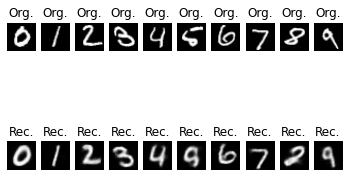

	 partial train loss (single batch): 8572.337891
	 partial train loss (single batch): 8498.656250
	 partial train loss (single batch): 7992.812988
	 partial train loss (single batch): 8241.291016
	 partial train loss (single batch): 8504.115234
	 partial train loss (single batch): 8383.446289
	 partial train loss (single batch): 8161.177734
	 partial train loss (single batch): 8274.229492
	 partial train loss (single batch): 8395.450195
	 partial train loss (single batch): 8275.753906
	 partial train loss (single batch): 8419.010742
	 partial train loss (single batch): 8393.789062
	 partial train loss (single batch): 8243.898438
	 partial train loss (single batch): 8400.123047
	 partial train loss (single batch): 8137.534180
	 partial train loss (single batch): 8200.018555
	 partial train loss (single batch): 8337.450195
	 partial train loss (single batch): 7857.106934
	 partial train loss (single batch): 8148.924316
	 partial train loss (single batch): 8437.268555
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

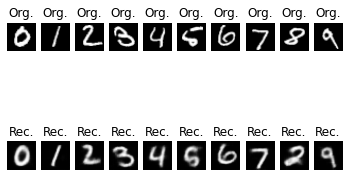

	 partial train loss (single batch): 8584.808594
	 partial train loss (single batch): 8562.437500
	 partial train loss (single batch): 8052.925293
	 partial train loss (single batch): 8208.273438
	 partial train loss (single batch): 8438.968750
	 partial train loss (single batch): 8331.162109
	 partial train loss (single batch): 8153.312012
	 partial train loss (single batch): 8243.608398
	 partial train loss (single batch): 8421.197266
	 partial train loss (single batch): 8226.631836
	 partial train loss (single batch): 8381.958008
	 partial train loss (single batch): 8417.839844
	 partial train loss (single batch): 8153.684082
	 partial train loss (single batch): 8299.385742
	 partial train loss (single batch): 8133.444336
	 partial train loss (single batch): 8205.417969
	 partial train loss (single batch): 8358.241211
	 partial train loss (single batch): 7868.898438
	 partial train loss (single batch): 8179.067383
	 partial train loss (single batch): 8503.110352
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

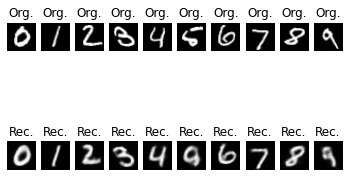

	 partial train loss (single batch): 8529.263672
	 partial train loss (single batch): 8553.118164
	 partial train loss (single batch): 8053.421875
	 partial train loss (single batch): 8216.207031
	 partial train loss (single batch): 8422.119141
	 partial train loss (single batch): 8243.654297
	 partial train loss (single batch): 8124.186035
	 partial train loss (single batch): 8213.633789
	 partial train loss (single batch): 8456.289062
	 partial train loss (single batch): 8231.455078
	 partial train loss (single batch): 8405.331055
	 partial train loss (single batch): 8323.079102
	 partial train loss (single batch): 8156.686035
	 partial train loss (single batch): 8217.552734
	 partial train loss (single batch): 8034.029785
	 partial train loss (single batch): 8138.045898
	 partial train loss (single batch): 8373.416016
	 partial train loss (single batch): 7876.220703
	 partial train loss (single batch): 8205.816406
	 partial train loss (single batch): 8519.451172
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

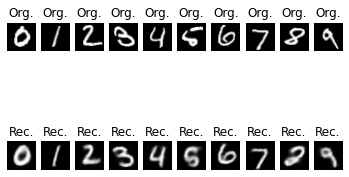

	 partial train loss (single batch): 8610.669922
	 partial train loss (single batch): 8442.499023
	 partial train loss (single batch): 8099.409180
	 partial train loss (single batch): 8181.470215
	 partial train loss (single batch): 8490.028320
	 partial train loss (single batch): 8233.761719
	 partial train loss (single batch): 8139.644531
	 partial train loss (single batch): 8298.082031
	 partial train loss (single batch): 8388.519531
	 partial train loss (single batch): 8185.965820
	 partial train loss (single batch): 8350.359375
	 partial train loss (single batch): 8331.722656
	 partial train loss (single batch): 8192.044922
	 partial train loss (single batch): 8258.308594
	 partial train loss (single batch): 8062.043945
	 partial train loss (single batch): 8250.003906
	 partial train loss (single batch): 8373.989258
	 partial train loss (single batch): 7926.645508
	 partial train loss (single batch): 8204.152344
	 partial train loss (single batch): 8408.849609
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

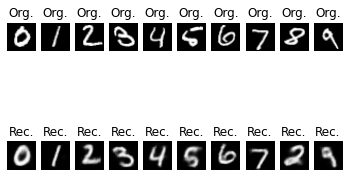

	 partial train loss (single batch): 8648.367188
	 partial train loss (single batch): 8480.193359
	 partial train loss (single batch): 7984.669434
	 partial train loss (single batch): 8204.232422
	 partial train loss (single batch): 8428.832031
	 partial train loss (single batch): 8356.212891
	 partial train loss (single batch): 8066.575195
	 partial train loss (single batch): 8235.357422
	 partial train loss (single batch): 8396.974609
	 partial train loss (single batch): 8202.846680
	 partial train loss (single batch): 8347.494141
	 partial train loss (single batch): 8403.926758
	 partial train loss (single batch): 8111.309570
	 partial train loss (single batch): 8205.574219
	 partial train loss (single batch): 8091.510742
	 partial train loss (single batch): 8133.999023
	 partial train loss (single batch): 8307.482422
	 partial train loss (single batch): 7817.937988
	 partial train loss (single batch): 8171.107910
	 partial train loss (single batch): 8432.769531
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

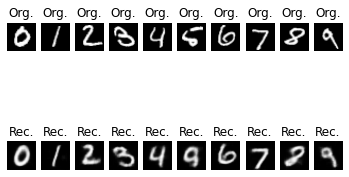

	 partial train loss (single batch): 8548.086914
	 partial train loss (single batch): 8524.875977
	 partial train loss (single batch): 7976.621094
	 partial train loss (single batch): 8152.477539
	 partial train loss (single batch): 8395.169922
	 partial train loss (single batch): 8301.311523
	 partial train loss (single batch): 8093.143555
	 partial train loss (single batch): 8138.509766
	 partial train loss (single batch): 8360.907227
	 partial train loss (single batch): 8194.630859
	 partial train loss (single batch): 8308.878906
	 partial train loss (single batch): 8277.861328
	 partial train loss (single batch): 8121.996094
	 partial train loss (single batch): 8243.162109
	 partial train loss (single batch): 8100.911133
	 partial train loss (single batch): 8174.095703
	 partial train loss (single batch): 8314.844727
	 partial train loss (single batch): 7858.853516
	 partial train loss (single batch): 8166.214844
	 partial train loss (single batch): 8480.132812
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

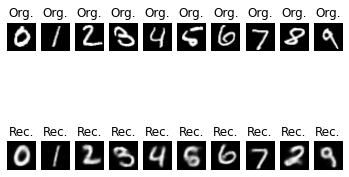

	 partial train loss (single batch): 8560.166016
	 partial train loss (single batch): 8471.802734
	 partial train loss (single batch): 8033.231445
	 partial train loss (single batch): 8178.708008
	 partial train loss (single batch): 8387.000977
	 partial train loss (single batch): 8250.380859
	 partial train loss (single batch): 8112.765625
	 partial train loss (single batch): 8261.149414
	 partial train loss (single batch): 8384.329102
	 partial train loss (single batch): 8241.677734
	 partial train loss (single batch): 8313.203125
	 partial train loss (single batch): 8372.269531
	 partial train loss (single batch): 8130.568359
	 partial train loss (single batch): 8218.692383
	 partial train loss (single batch): 8071.057617
	 partial train loss (single batch): 8152.010742
	 partial train loss (single batch): 8309.234375
	 partial train loss (single batch): 7841.924805
	 partial train loss (single batch): 8134.114258
	 partial train loss (single batch): 8340.966797
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

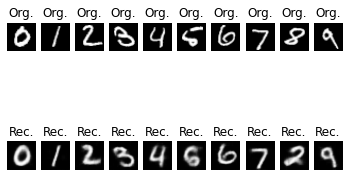

	 partial train loss (single batch): 8520.833008
	 partial train loss (single batch): 8493.151367
	 partial train loss (single batch): 8016.235840
	 partial train loss (single batch): 8138.461914
	 partial train loss (single batch): 8415.723633
	 partial train loss (single batch): 8233.167969
	 partial train loss (single batch): 8118.993164
	 partial train loss (single batch): 8219.694336
	 partial train loss (single batch): 8331.701172
	 partial train loss (single batch): 8226.374023
	 partial train loss (single batch): 8384.197266
	 partial train loss (single batch): 8350.830078
	 partial train loss (single batch): 8077.468262
	 partial train loss (single batch): 8261.114258
	 partial train loss (single batch): 8006.275391
	 partial train loss (single batch): 8125.600586
	 partial train loss (single batch): 8295.359375
	 partial train loss (single batch): 7757.356934
	 partial train loss (single batch): 8110.116211
	 partial train loss (single batch): 8417.308594
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

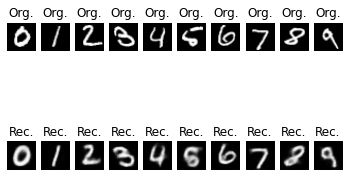

	 partial train loss (single batch): 8508.212891
	 partial train loss (single batch): 8508.234375
	 partial train loss (single batch): 8054.617676
	 partial train loss (single batch): 8125.832031
	 partial train loss (single batch): 8469.632812
	 partial train loss (single batch): 8290.578125
	 partial train loss (single batch): 8124.986328
	 partial train loss (single batch): 8158.520020
	 partial train loss (single batch): 8342.519531
	 partial train loss (single batch): 8221.673828
	 partial train loss (single batch): 8343.605469
	 partial train loss (single batch): 8318.522461
	 partial train loss (single batch): 8044.721680
	 partial train loss (single batch): 8232.187500
	 partial train loss (single batch): 8008.931152
	 partial train loss (single batch): 8201.447266
	 partial train loss (single batch): 8293.486328
	 partial train loss (single batch): 7807.208984
	 partial train loss (single batch): 8104.378418
	 partial train loss (single batch): 8401.750000
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

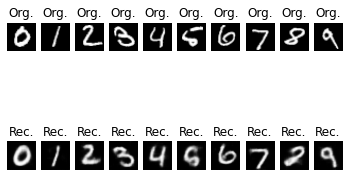

	 partial train loss (single batch): 8526.347656
	 partial train loss (single batch): 8507.319336
	 partial train loss (single batch): 7946.141602
	 partial train loss (single batch): 8156.974609
	 partial train loss (single batch): 8443.542969
	 partial train loss (single batch): 8206.500977
	 partial train loss (single batch): 8101.864258
	 partial train loss (single batch): 8127.912109
	 partial train loss (single batch): 8342.091797
	 partial train loss (single batch): 8118.858398
	 partial train loss (single batch): 8342.733398
	 partial train loss (single batch): 8335.648438
	 partial train loss (single batch): 8136.379883
	 partial train loss (single batch): 8177.861328
	 partial train loss (single batch): 7985.280273
	 partial train loss (single batch): 8076.986328
	 partial train loss (single batch): 8254.440430
	 partial train loss (single batch): 7800.881348
	 partial train loss (single batch): 8147.538086
	 partial train loss (single batch): 8315.632812
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

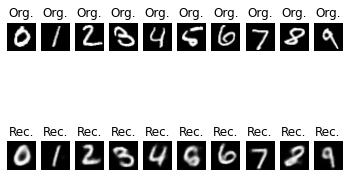

	 partial train loss (single batch): 8511.660156
	 partial train loss (single batch): 8524.375000
	 partial train loss (single batch): 7976.649414
	 partial train loss (single batch): 8168.264648
	 partial train loss (single batch): 8387.886719
	 partial train loss (single batch): 8190.854492
	 partial train loss (single batch): 8055.903320
	 partial train loss (single batch): 8155.831055
	 partial train loss (single batch): 8365.148438
	 partial train loss (single batch): 8136.591309
	 partial train loss (single batch): 8343.741211
	 partial train loss (single batch): 8305.492188
	 partial train loss (single batch): 8057.358887
	 partial train loss (single batch): 8199.629883
	 partial train loss (single batch): 8040.789062
	 partial train loss (single batch): 8130.494141
	 partial train loss (single batch): 8201.082031
	 partial train loss (single batch): 7816.583496
	 partial train loss (single batch): 8057.473633
	 partial train loss (single batch): 8412.863281
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

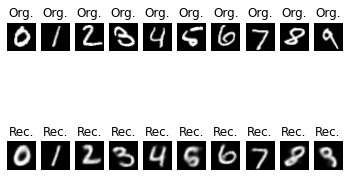

	 partial train loss (single batch): 8558.326172
	 partial train loss (single batch): 8418.302734
	 partial train loss (single batch): 7968.429688
	 partial train loss (single batch): 8132.569336
	 partial train loss (single batch): 8429.631836
	 partial train loss (single batch): 8283.349609
	 partial train loss (single batch): 8079.085938
	 partial train loss (single batch): 8236.579102
	 partial train loss (single batch): 8294.068359
	 partial train loss (single batch): 8163.990234
	 partial train loss (single batch): 8291.851562
	 partial train loss (single batch): 8321.174805
	 partial train loss (single batch): 8057.526367
	 partial train loss (single batch): 8144.838867
	 partial train loss (single batch): 7996.489258
	 partial train loss (single batch): 8161.192383
	 partial train loss (single batch): 8312.814453
	 partial train loss (single batch): 7779.128418
	 partial train loss (single batch): 8090.494141
	 partial train loss (single batch): 8366.863281
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

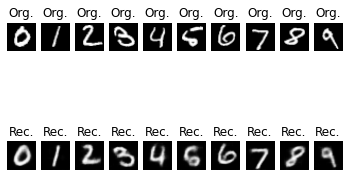

	 partial train loss (single batch): 8527.179688
	 partial train loss (single batch): 8498.020508
	 partial train loss (single batch): 8044.971680
	 partial train loss (single batch): 8084.195801
	 partial train loss (single batch): 8353.917969
	 partial train loss (single batch): 8231.388672
	 partial train loss (single batch): 8104.042969
	 partial train loss (single batch): 8152.152344
	 partial train loss (single batch): 8341.972656
	 partial train loss (single batch): 8131.075195
	 partial train loss (single batch): 8318.040039
	 partial train loss (single batch): 8320.379883
	 partial train loss (single batch): 8028.126953
	 partial train loss (single batch): 8157.440918
	 partial train loss (single batch): 7994.500977
	 partial train loss (single batch): 8055.111816
	 partial train loss (single batch): 8257.394531
	 partial train loss (single batch): 7783.492676
	 partial train loss (single batch): 8119.824707
	 partial train loss (single batch): 8313.816406
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

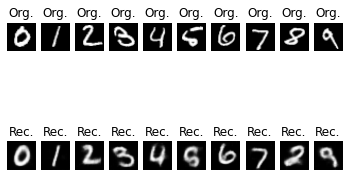

	 partial train loss (single batch): 8497.191406
	 partial train loss (single batch): 8406.687500
	 partial train loss (single batch): 7971.901367
	 partial train loss (single batch): 8144.026855
	 partial train loss (single batch): 8342.803711
	 partial train loss (single batch): 8154.405762
	 partial train loss (single batch): 8129.107422
	 partial train loss (single batch): 8217.449219
	 partial train loss (single batch): 8251.518555
	 partial train loss (single batch): 8151.879395
	 partial train loss (single batch): 8309.318359
	 partial train loss (single batch): 8314.580078
	 partial train loss (single batch): 8082.166016
	 partial train loss (single batch): 8164.202148
	 partial train loss (single batch): 7938.087402
	 partial train loss (single batch): 8139.744629
	 partial train loss (single batch): 8285.627930
	 partial train loss (single batch): 7797.204102
	 partial train loss (single batch): 8075.379395
	 partial train loss (single batch): 8390.238281
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

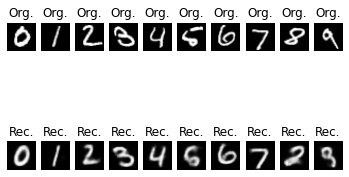

	 partial train loss (single batch): 8521.403320
	 partial train loss (single batch): 8401.460938
	 partial train loss (single batch): 8095.980957
	 partial train loss (single batch): 8146.481445
	 partial train loss (single batch): 8309.666016
	 partial train loss (single batch): 8167.518066
	 partial train loss (single batch): 8034.773438
	 partial train loss (single batch): 8102.080566
	 partial train loss (single batch): 8370.951172
	 partial train loss (single batch): 8145.323242
	 partial train loss (single batch): 8296.941406
	 partial train loss (single batch): 8350.538086
	 partial train loss (single batch): 8071.678711
	 partial train loss (single batch): 8179.301758
	 partial train loss (single batch): 7945.150391
	 partial train loss (single batch): 8122.767578
	 partial train loss (single batch): 8244.322266
	 partial train loss (single batch): 7768.530762
	 partial train loss (single batch): 7960.056641
	 partial train loss (single batch): 8369.836914
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

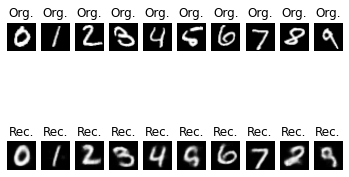

	 partial train loss (single batch): 8448.729492
	 partial train loss (single batch): 8398.258789
	 partial train loss (single batch): 7935.858887
	 partial train loss (single batch): 8164.178711
	 partial train loss (single batch): 8314.310547
	 partial train loss (single batch): 8186.541992
	 partial train loss (single batch): 8112.979980
	 partial train loss (single batch): 8135.015625
	 partial train loss (single batch): 8260.810547
	 partial train loss (single batch): 8092.028320
	 partial train loss (single batch): 8283.236328
	 partial train loss (single batch): 8319.233398
	 partial train loss (single batch): 8112.436523
	 partial train loss (single batch): 8068.548340
	 partial train loss (single batch): 7988.330078
	 partial train loss (single batch): 8188.691895
	 partial train loss (single batch): 8264.923828
	 partial train loss (single batch): 7767.029785
	 partial train loss (single batch): 8136.598145
	 partial train loss (single batch): 8352.905273
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

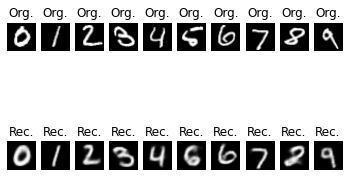

	 partial train loss (single batch): 8482.687500
	 partial train loss (single batch): 8338.438477
	 partial train loss (single batch): 7976.639648
	 partial train loss (single batch): 8101.064453
	 partial train loss (single batch): 8355.766602
	 partial train loss (single batch): 8158.340332
	 partial train loss (single batch): 8051.170898
	 partial train loss (single batch): 8185.739258
	 partial train loss (single batch): 8333.551758
	 partial train loss (single batch): 8152.833008
	 partial train loss (single batch): 8246.228516
	 partial train loss (single batch): 8291.123047
	 partial train loss (single batch): 8058.996094
	 partial train loss (single batch): 8172.347656
	 partial train loss (single batch): 8018.163086
	 partial train loss (single batch): 8156.570312
	 partial train loss (single batch): 8251.398438
	 partial train loss (single batch): 7775.560547
	 partial train loss (single batch): 8105.463867
	 partial train loss (single batch): 8291.703125
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

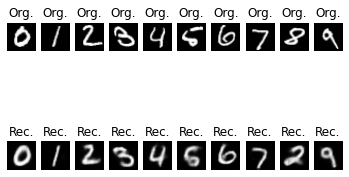

	 partial train loss (single batch): 8412.709961
	 partial train loss (single batch): 8319.150391
	 partial train loss (single batch): 8026.856445
	 partial train loss (single batch): 8043.796875
	 partial train loss (single batch): 8357.107422
	 partial train loss (single batch): 8274.658203
	 partial train loss (single batch): 8074.720703
	 partial train loss (single batch): 8249.320312
	 partial train loss (single batch): 8314.535156
	 partial train loss (single batch): 8136.927246
	 partial train loss (single batch): 8232.115234
	 partial train loss (single batch): 8256.250000
	 partial train loss (single batch): 8063.437988
	 partial train loss (single batch): 8202.960938
	 partial train loss (single batch): 8006.180176
	 partial train loss (single batch): 8061.125488
	 partial train loss (single batch): 8247.597656
	 partial train loss (single batch): 7765.027832
	 partial train loss (single batch): 8079.462891
	 partial train loss (single batch): 8324.505859
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

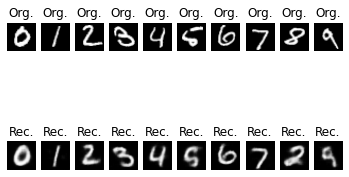

	 partial train loss (single batch): 8448.215820
	 partial train loss (single batch): 8408.812500
	 partial train loss (single batch): 7970.279297
	 partial train loss (single batch): 8065.399414
	 partial train loss (single batch): 8352.176758
	 partial train loss (single batch): 8128.992188
	 partial train loss (single batch): 7961.758301
	 partial train loss (single batch): 8118.120605
	 partial train loss (single batch): 8277.389648
	 partial train loss (single batch): 8156.733887
	 partial train loss (single batch): 8240.296875
	 partial train loss (single batch): 8288.538086
	 partial train loss (single batch): 8030.679688
	 partial train loss (single batch): 8150.000000
	 partial train loss (single batch): 7955.252441
	 partial train loss (single batch): 8064.345703
	 partial train loss (single batch): 8216.495117
	 partial train loss (single batch): 7822.305664
	 partial train loss (single batch): 8101.125000
	 partial train loss (single batch): 8300.438477
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

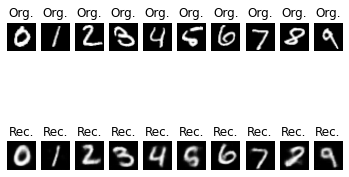

	 partial train loss (single batch): 8469.777344
	 partial train loss (single batch): 8337.056641
	 partial train loss (single batch): 7921.472656
	 partial train loss (single batch): 8031.630859
	 partial train loss (single batch): 8314.664062
	 partial train loss (single batch): 8228.794922
	 partial train loss (single batch): 7987.624023
	 partial train loss (single batch): 8148.320801
	 partial train loss (single batch): 8304.611328
	 partial train loss (single batch): 8109.966797
	 partial train loss (single batch): 8264.839844
	 partial train loss (single batch): 8231.576172
	 partial train loss (single batch): 7929.918457
	 partial train loss (single batch): 8146.742676
	 partial train loss (single batch): 7931.131836
	 partial train loss (single batch): 8039.810547
	 partial train loss (single batch): 8278.908203
	 partial train loss (single batch): 7795.950684
	 partial train loss (single batch): 8059.419434
	 partial train loss (single batch): 8243.657227
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

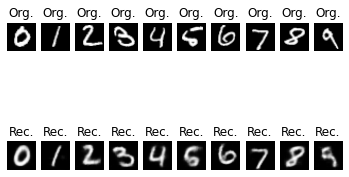

	 partial train loss (single batch): 8448.876953
	 partial train loss (single batch): 8424.156250
	 partial train loss (single batch): 7970.284180
	 partial train loss (single batch): 8047.464355
	 partial train loss (single batch): 8395.761719
	 partial train loss (single batch): 8149.651367
	 partial train loss (single batch): 8075.000000
	 partial train loss (single batch): 8139.488770
	 partial train loss (single batch): 8280.933594
	 partial train loss (single batch): 8101.658203
	 partial train loss (single batch): 8211.767578
	 partial train loss (single batch): 8220.256836
	 partial train loss (single batch): 8024.618652
	 partial train loss (single batch): 8126.805664
	 partial train loss (single batch): 7917.557617
	 partial train loss (single batch): 8148.466309
	 partial train loss (single batch): 8265.935547
	 partial train loss (single batch): 7713.474609
	 partial train loss (single batch): 8114.377930
	 partial train loss (single batch): 8279.001953
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

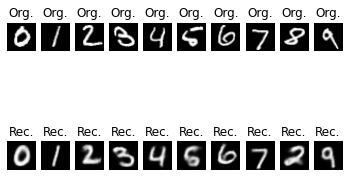

	 partial train loss (single batch): 8472.882812
	 partial train loss (single batch): 8371.004883
	 partial train loss (single batch): 7948.082031
	 partial train loss (single batch): 8071.223633
	 partial train loss (single batch): 8342.318359
	 partial train loss (single batch): 8235.988281
	 partial train loss (single batch): 8032.356934
	 partial train loss (single batch): 8145.287598
	 partial train loss (single batch): 8264.615234
	 partial train loss (single batch): 8144.797852
	 partial train loss (single batch): 8295.543945
	 partial train loss (single batch): 8271.845703
	 partial train loss (single batch): 8081.250000
	 partial train loss (single batch): 8165.034180
	 partial train loss (single batch): 7944.592773
	 partial train loss (single batch): 8013.704102
	 partial train loss (single batch): 8269.345703
	 partial train loss (single batch): 7773.622559
	 partial train loss (single batch): 8029.666992
	 partial train loss (single batch): 8306.031250
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

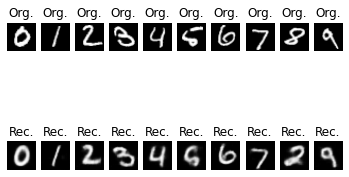

	 partial train loss (single batch): 8458.791016
	 partial train loss (single batch): 8299.410156
	 partial train loss (single batch): 7991.040039
	 partial train loss (single batch): 8087.702148
	 partial train loss (single batch): 8341.848633
	 partial train loss (single batch): 8154.143555
	 partial train loss (single batch): 8027.207031
	 partial train loss (single batch): 8195.708984
	 partial train loss (single batch): 8300.584961
	 partial train loss (single batch): 8094.233398
	 partial train loss (single batch): 8276.121094
	 partial train loss (single batch): 8267.523438
	 partial train loss (single batch): 8002.245605
	 partial train loss (single batch): 8130.177734
	 partial train loss (single batch): 7969.357422
	 partial train loss (single batch): 8040.796875
	 partial train loss (single batch): 8219.843750
	 partial train loss (single batch): 7785.753418
	 partial train loss (single batch): 8075.315918
	 partial train loss (single batch): 8298.412109
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

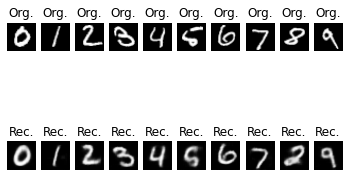

	 partial train loss (single batch): 8474.977539
	 partial train loss (single batch): 8369.688477
	 partial train loss (single batch): 7907.367188
	 partial train loss (single batch): 8079.059570
	 partial train loss (single batch): 8368.854492
	 partial train loss (single batch): 8149.485352
	 partial train loss (single batch): 8061.739258
	 partial train loss (single batch): 8121.117188
	 partial train loss (single batch): 8269.370117
	 partial train loss (single batch): 8099.303223
	 partial train loss (single batch): 8180.387207
	 partial train loss (single batch): 8246.546875
	 partial train loss (single batch): 8046.776367
	 partial train loss (single batch): 8213.335938
	 partial train loss (single batch): 7935.535156
	 partial train loss (single batch): 8151.228516
	 partial train loss (single batch): 8197.914062
	 partial train loss (single batch): 7709.420410
	 partial train loss (single batch): 8066.959473
	 partial train loss (single batch): 8334.919922
	 partial train loss

<Figure size 2880x2880 with 0 Axes>

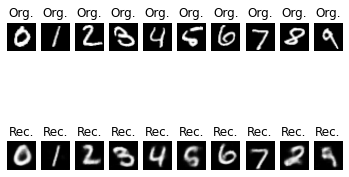

In [ ]:
num_epochs = 50

for epoch in range(num_epochs):
  train_loss = train_epoch(vae,device,train_loader,optim)
  val_loss = test_epoch(vae,device,valid_loader)
  print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  plot_ae_outputs(vae.encoder,vae.decoder,n=10)

# Vector Quantized Variational Autoencoder ([VQ-VAE](https://arxiv.org/pdf/1711.00937.pdf))

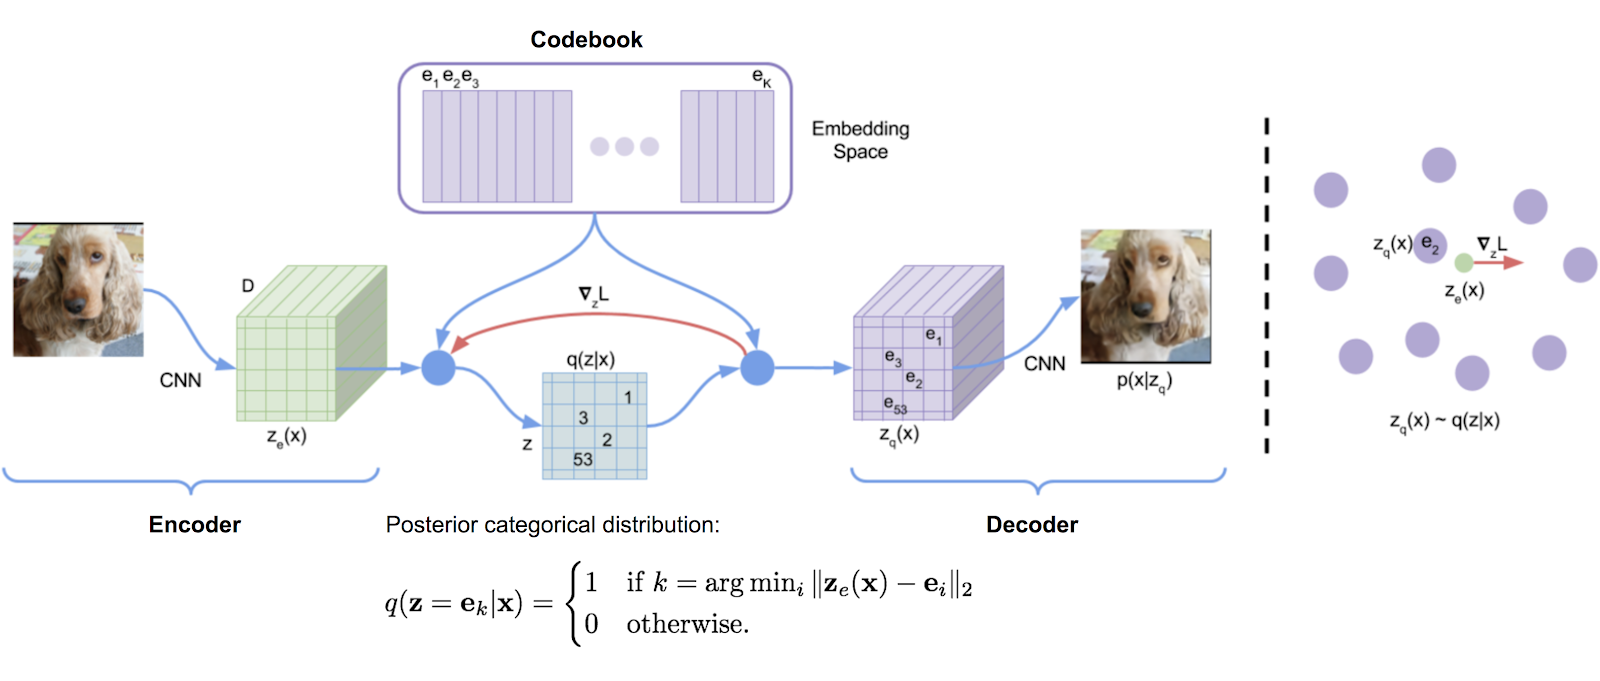

The main difference between a VAE and a VQ-VAE is that VAE learns a continuous latent representation, whereas VQ-VAE learns a discrate latent representaiton.

So far we have seen how continuous vector spaces can be used to represent the latents in an autoencoder. But latents do not necessarily need to be continuous vectors, it really just needs to be some numerical representation for the data. And one such, potentially desirable, alternative to a vector space is a discrete representation.

n general, a lot of the data we encounter in the real world favors a discrete representation. For example, human speech is well represented by discrete phonemes and language. Additionally, images contain discrete objects with some discrete set of qualifiers. You could imagine having one discrete variable for the type of object, one for its color, one for its size, one for its orientation, one for its shape, one for its texture, one for the background color, one for the background texture, etc…

In addition to the representation, there are a number of algorithms (like transformers) that are designed to work on discrete data, so we would like to have a discrete representation of the data for these algorithms to use.

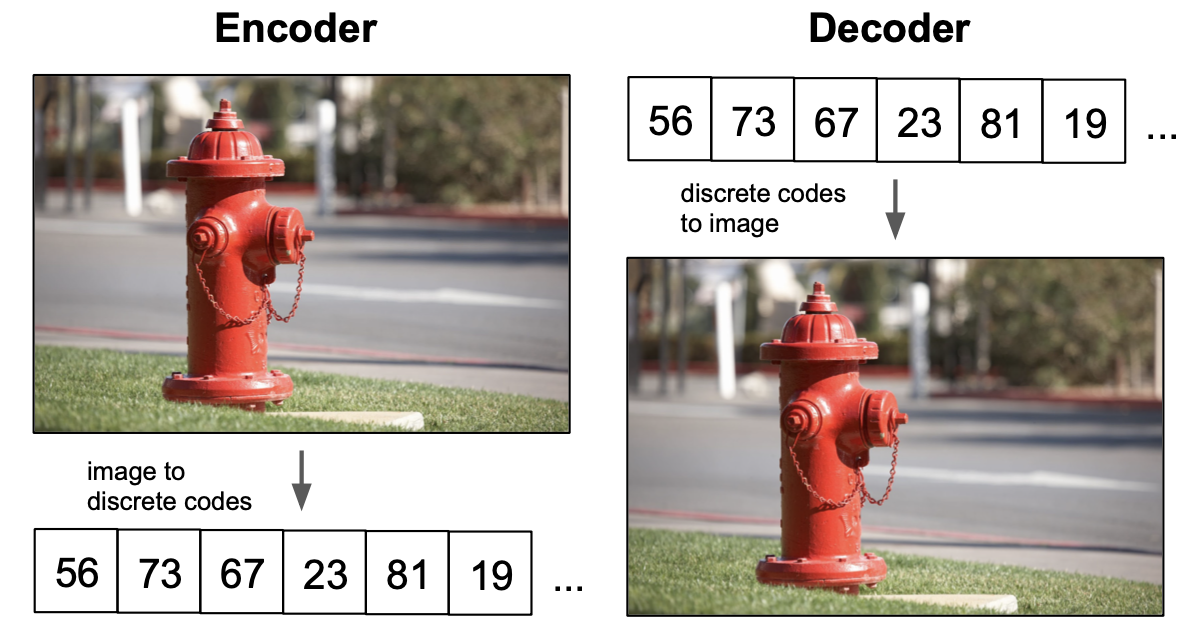

Clearly discrete latent representations can be useful, but how do we learn such a representation? This might seem very challenging at first because in general discrete things do not play too nicely with deep learning. Luckily enough, VQ-VAE manages to make deep learning work for the task with just a few tweaks to the vanilla autoencoder paradigm.

## How does the VQ-VAE extend VAE

VQ-VAE extends the standard autoencoder by adding a discrete codebook component to the network. The codebook is basically a list of vectors associated with a corresponding index. It is used to quantize the bottleneck of the autoencoder; the output of the encoder network is compared to all the vectors in the codebook, and the codebook vector closest in euclidean distance is fed to the decoder.

Mathematically this is written as $z_q(x)=\text{argmin}_i ||z_e(x)-e_i||_2$, where $z_e(x)$ is the encoder vector for some raw input $x$, $e_i$ is the i-th codebook vector, and $z_q(x)$ is the resulting quantized vector that is passed as input to the decoder.

This argmin operation is a bit concerning, since it is non-differentiable with respect to the encoder. But in practice everything seems to work fine if you just pass the decoder gradient directly through this operation to the encoder (i.e. set its gradient to 1 w.r.t. the encoder and the quantized codebook vector; and to 0 wrt all other codebook vectors)

The decoder is then tasked with reconstructing the input from this quantized vector as in the standard autoencoder formulation.

### Producing Multiple Codes

You might be puzzled by the fact that there is such a restricted set of vectors that can be fed to the decoder (just the set of codebook vectors). How could one ever expect to generate the huge quantity and diversity of possible images when the decoder can only accept the set of codebook vectors as input? We would need a unique discrete value for each training point to be able to reconstruct all the data. And if this is actually the case, then wouldn’t the model effectively be memorizing the data by mapping each training point to a different discrete code?

This would be a very valid concern if the encoder were to output just one vector, but in actual VQ-VAEs the encoder usually produces a series of vectors. For instance, with images, the encoder might output a 32x32 grid of vectors, each of these are quantized and then the entire grid is fed to the decoder. Or similarly, for processing audio, the encoder could output a long 1-d sequence of vectors. All vectors are quantized to the same codebook, so the number of discrete values doesn’t change, but by outputting multiple codes we are able to exponentially increase the number of datapoints our decoder can construct.

For instance, imagine we are working with images, we have a codebook of size 512, and our encoder outputs a 32x32 grid of vectors. In this case, our decoder can output $512^{32\cdot 32}=2^{9216}$ distinct images! Just to make it clear how enormous this number is, I have computed it in python in the figure below… it is truly an unfathomably large number. There is absolutely no way anyone could ever visualize every possible output from this model. The size of the discrete space really is no longer a problem here.

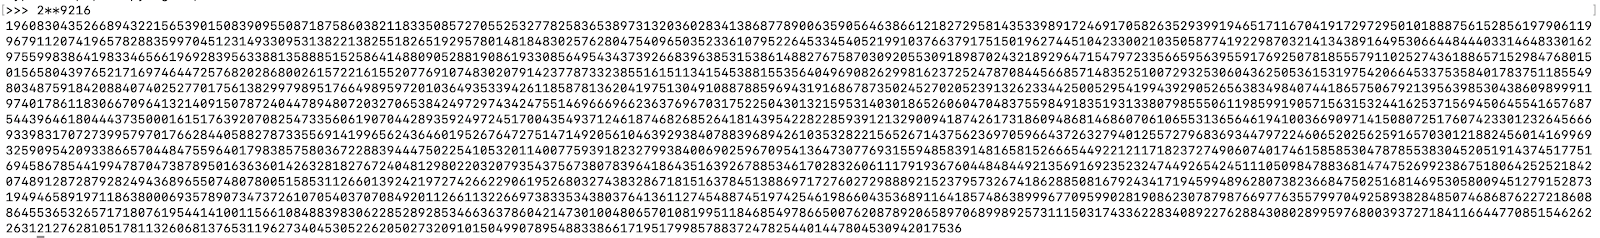

Of course the model could still memorize the training data, but with the right inductive biases baked into the encoder (i.e. using a conv-net for images) and the right structure for the latent codes (i.e. a 32x32 grid for images), the model should learn a discrete space that represents the data well.

### Learning the **Codebook**

Just like the encoder and decoder networks, the codebook vectors are learned via gradient descent. Ideally our encoder with output vectors that are generally close to one of the learned codebook vectors. There is essentially a bi-directional problem here: learning codebook vectors that align to the encoder outputs and and learning encoder outputs that align to a codebook vector.

Both of these problems are solved by adding terms to the loss function. The entire VQ-VAE loss function is

$\text{log}(p(x|q(x)))+||\text{sg}[z_e(x)]-e||_2^2+\beta||z_e(x)-\text{sg}[e]||^2_2$


$\text{sg}[x]$ stands for “stop gradient”, it prevents the gradient from flowing through that part of the equation.

The first term is just the standard reconstruction loss. The second term is the codebook alignment loss, whose goal is to get the chosen codebook vector as close to the encoder output as possible. There is a stop gradient operator on the encoder output because this term is only intended to update the codebook. And the third term is similar to the second, but it puts the stop gradient on the codebook vector instead because it is meant to solve the inverse problem of getting the encoder output to commit as much as possible to its closest codebook vector. This term is called the codebook commitment loss, and its importance to the overall loss is scaled by the tunable hyperparameter $\beta$. Of course these last two terms are averaged over each quantized vector output from the model, if there is more than one.

With this, we can fully train a VQ-VAE capable of reconstructing a diverse set of images that are almost imperceptibly different from the original images as seen in the figure below. We can also train VQ-VAEs to reconstruct other modalities like audio or video.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [ ]:
# Model Hyperparameters

dataset_path = '/content/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 128
img_size = (32, 32) # (width, height)

input_dim = 3
hidden_dim = 128
n_embeddings= 768
output_dim = 3

lr = 2e-4

epochs = 50

print_step = 50

## Load or download the dataset

In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False,  **kwargs)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/datasets/cifar-10-python.tar.gz to /content/datasets
Files already downloaded and verified


## Define our model: VQ-VAE


In [ ]:
class Encoder(nn.Module):
    
  def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
    super(Encoder, self).__init__()
    
    kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
    
    self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
    self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
    
    self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
    self.residual_conv_2 = nn.Conv2d(hidden_dim, output_dim, kernel_4, padding=0)
      
  def forward(self, x):
      
    x = self.strided_conv_1(x)
    x = self.strided_conv_2(x)
    
    x = F.relu(x)
    y = self.residual_conv_1(x)
    y = y+x
    
    x = F.relu(y)
    y = self.residual_conv_2(x)
    y = y+x
    
    return y

In [ ]:
class VQEmbeddingEMA(nn.Module):
  def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
    super(VQEmbeddingEMA, self).__init__()
    self.commitment_cost = commitment_cost
    self.decay = decay
    self.epsilon = epsilon
    
    init_bound = 1 / n_embeddings
    embedding = torch.Tensor(n_embeddings, embedding_dim)
    embedding.uniform_(-init_bound, init_bound)
    self.register_buffer("embedding", embedding)
    self.register_buffer("ema_count", torch.zeros(n_embeddings))
    self.register_buffer("ema_weight", self.embedding.clone())

  def encode(self, x):
    M, D = self.embedding.size()
    x_flat = x.detach().reshape(-1, D)

    distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                torch.sum(x_flat ** 2, dim=1, keepdim=True),
                            x_flat, self.embedding.t(),
                            alpha=-2.0, beta=1.0)

    indices = torch.argmin(distances.float(), dim=-1)
    quantized = F.embedding(indices, self.embedding)
    quantized = quantized.view_as(x)
    return quantized, indices.view(x.size(0), x.size(1))
  
  def retrieve_random_codebook(self, random_indices):
    quantized = F.embedding(random_indices, self.embedding)
    quantized = quantized.transpose(1, 3)
    
    return quantized

  def forward(self, x):
    M, D = self.embedding.size()
    x_flat = x.detach().reshape(-1, D)
    
    distances = torch.addmm(torch.sum(self.embedding ** 2, dim=1) +
                            torch.sum(x_flat ** 2, dim=1, keepdim=True),
                            x_flat, self.embedding.t(),
                            alpha=-2.0, beta=1.0)

    indices = torch.argmin(distances.float(), dim=-1)
    encodings = F.one_hot(indices, M).float()
    quantized = F.embedding(indices, self.embedding)
    quantized = quantized.view_as(x)
    
    if self.training:
      self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
      n = torch.sum(self.ema_count)
      self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

      dw = torch.matmul(encodings.t(), x_flat)
      self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
      self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

    codebook_loss = F.mse_loss(x.detach(), quantized)
    e_latent_loss = F.mse_loss(x, quantized.detach())
    commitment_loss = self.commitment_cost * e_latent_loss

    quantized = x + (quantized - x).detach()

    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    return quantized, commitment_loss, codebook_loss, perplexity

In [ ]:
class Decoder(nn.Module):
    
  def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
    super(Decoder, self).__init__()
    
    kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
    
    self.residual_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, padding=0)
    self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
    
    self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
    self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
      
  def forward(self, x):
      
    y = self.residual_conv_1(x)
    y = y+x
    x = F.relu(y)
    
    y = self.residual_conv_2(x)
    y = y+x
    y = F.relu(y)
    
    y = self.strided_t_conv_1(y)
    y = self.strided_t_conv_2(y)
    
    return y

In [ ]:
class Model(nn.Module):
  def __init__(self, Encoder, Codebook, Decoder):
    super(Model, self).__init__()
    self.encoder = Encoder
    self.codebook = Codebook
    self.decoder = Decoder
              
  def forward(self, x):
    z = self.encoder(x)
    z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
    x_hat = self.decoder(z_quantized)
    
    return x_hat, commitment_loss, codebook_loss, perplexity

In [ ]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=hidden_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=hidden_dim)
decoder = Decoder(input_dim=hidden_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

## Define Loss function (reprod. loss) and optimizer


In [ ]:
from torch.optim import Adam

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

## Train Vector Quantized Variational AutoEncoder (VQ-VAE)


In [ ]:
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
  overall_loss = 0
  for batch_idx, (x, _) in enumerate(train_loader):
    x = x.to(DEVICE)

    optimizer.zero_grad()

    x_hat, commitment_loss, codebook_loss, perplexity = model(x)
    recon_loss = mse_loss(x_hat, x)
    
    loss =  recon_loss + commitment_loss + codebook_loss
            
    loss.backward()
    optimizer.step()
    
    if batch_idx % print_step ==0: 
      print("epoch:", epoch + 1, "  step:", batch_idx + 1, "  recon_loss:", recon_loss.item(), "  perplexity: ", perplexity.item(), 
          "\n\t\tcommit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item(), "  total_loss: ", loss.item())
  
print("Finish!!")

Start training VQ-VAE...
epoch: 1   step: 1   recon_loss: 0.39015182852745056   perplexity:  53.499786376953125 
		commit_loss:  0.00531123299151659   codebook loss:  0.02124493196606636   total_loss:  0.41670799255371094
epoch: 1   step: 51   recon_loss: 0.05558770149946213   perplexity:  24.91668128967285 
		commit_loss:  0.024134106934070587   codebook loss:  0.09653642773628235   total_loss:  0.17625823616981506
epoch: 1   step: 101   recon_loss: 0.049059152603149414   perplexity:  27.352230072021484 
		commit_loss:  0.04284360259771347   codebook loss:  0.17137441039085388   total_loss:  0.26327717304229736
epoch: 1   step: 151   recon_loss: 0.037652358412742615   perplexity:  52.86086654663086 
		commit_loss:  0.04024636372923851   codebook loss:  0.16098545491695404   total_loss:  0.23888418078422546
epoch: 1   step: 201   recon_loss: 0.03344746679067612   perplexity:  77.65776824951172 
		commit_loss:  0.035024043172597885   codebook loss:  0.14009617269039154   total_loss:  0.

## Evaluating the VQ-VAE

In [ ]:
import matplotlib.pyplot as plt

def draw_sample_image(x, postfix):

  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Visualization of {}".format(postfix))
  plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))


model.eval()

with torch.no_grad():

  for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

    x = x.to(DEVICE)
    x_hat, commitment_loss, codebook_loss, perplexity = model(x)

    print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
    break

  0%|          | 0/79 [00:00<?, ?it/s]

perplexity:  655.8692626953125 commit_loss:  0.02682744711637497   codebook loss:  0.10730978846549988


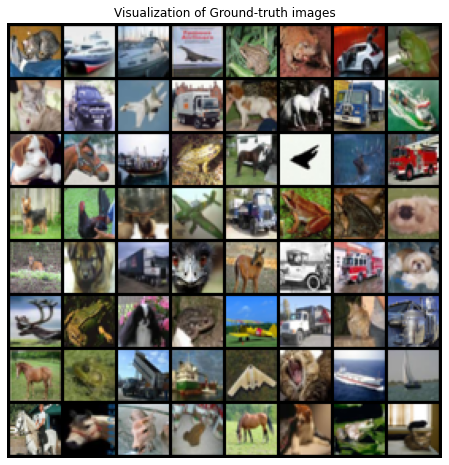

In [ ]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")

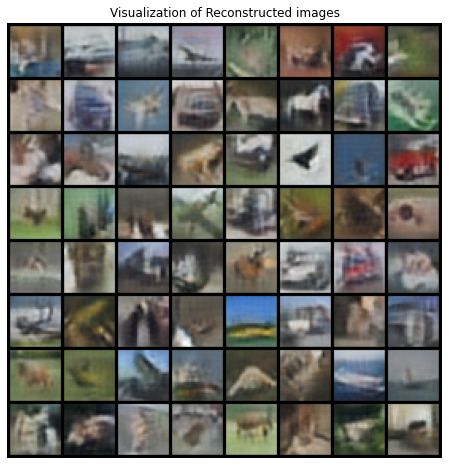

In [ ]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")

## Generate samples via random codes

In [ ]:
def draw_random_sample_image(codebook, decoder, indices_shape):
  random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(DEVICE)
  codes = codebook.retrieve_random_codebook(random_indices)
  x_hat = decoder(codes.to(DEVICE))
  
  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.title("Visualization of Random Codes")
  plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

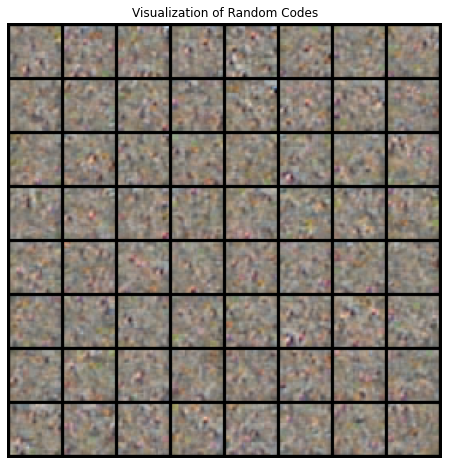

In [ ]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, img_size[0]//4, img_size[1]//4))

## Interpreting VQ-VAE in the language of VAEs

Now that we know how VQ-VAEs work, let’s try to understand them in the context of the probabilistic formalism that VAEs provide. Recall that VAEs enforce a pre-defined prior on the latent space $p(z)$, and the encoder is tasked with approximating the posterior distribution of the latents $p(z|x)$. Lastly, the decoder approximates the reconstruction from the latent space $p(x|z)$.

During training, VQ-VAE assumes a uniform prior over all the latent codes, so all latents are considered equally likely. Additionally the posterior is deterministic in that $p(z|x)=1$ if $z=z_q(x)$ and 0 otherwise. Lastly, the decoder distribution $p(x|z)$ is unchanged and learned as usual. Using these definitions, it can easily be shown that the KL divergence term from the VAE loss becomes a constant and therefore can be dropped for VQ-VAEs, leaving just the reconstruction term. The VQ-VAE reconstruction loss is therefore consistent with VAE formalism.

## Learning the Prior

Once a VQ-VAE is fully trained, we can abandon the uniform prior imposed at training time and learn a new, updated prior $p(z)$ over the latents. If we learn a prior that accurately represents the distribution of discrete codes, we will be able to generate new data from the distribution by sampling from this prior and feeding the samples to the decoder (see the figure below for original VQ-VAE samples).

Training the prior also has compression benefits. If the distribution of latents is non-uniform, then the bits representing the sequence of latents can be further compressed by applying standard huffman or arithmetic coding to the prior distribution.

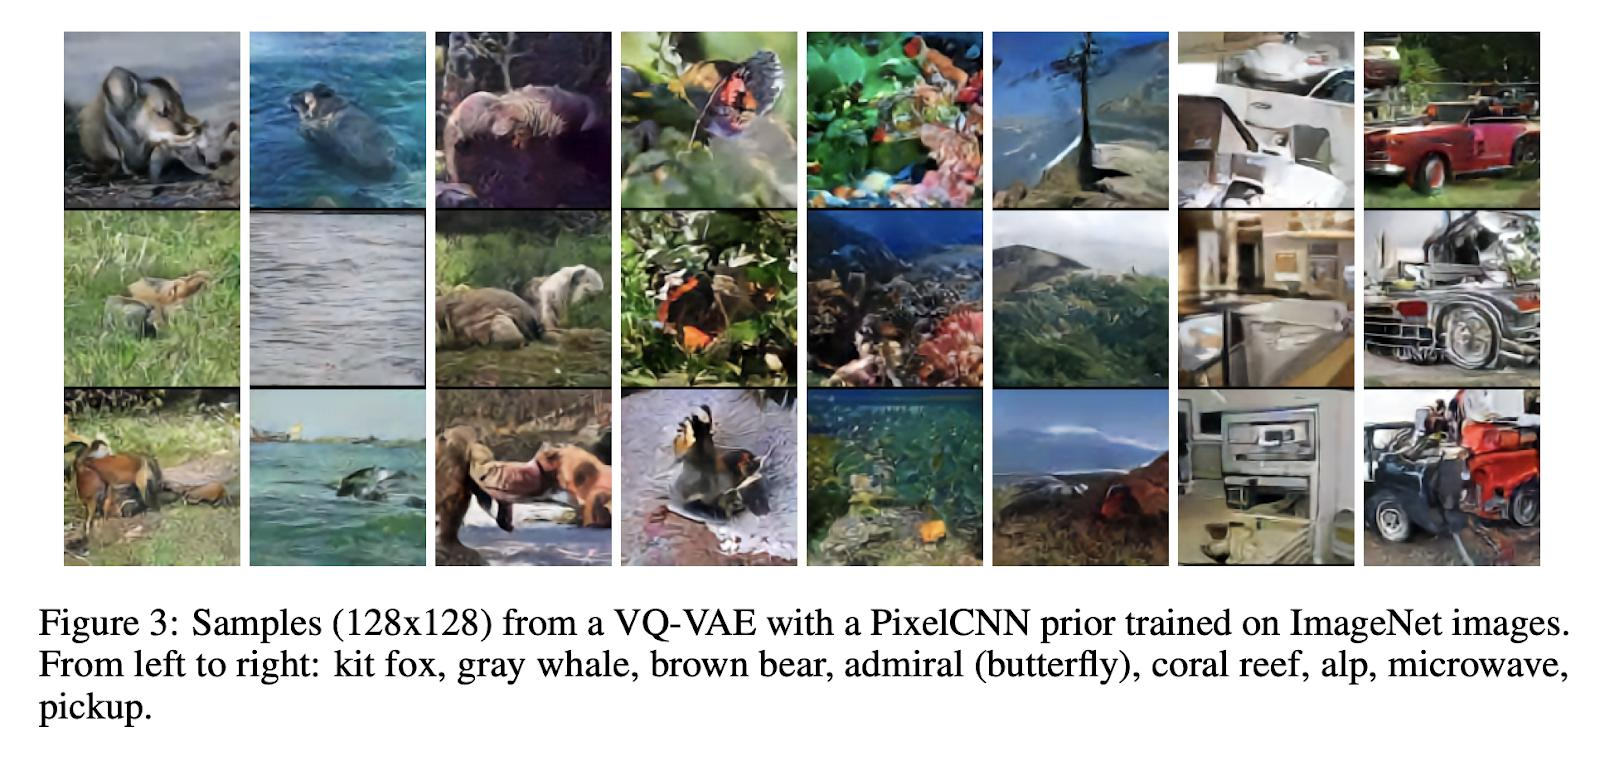

Assuming the encoder outputs a sequence of latent codes for each datapoint, we can use any autoregressive model we want (i.e. RNN or transformer) to train the prior. The autoregressive factorization is, given all previous latent codes in the sequence, predict the next one. This breaks the latent distribution down as $p(z)=p(z_1)p(z_2|z_1)p(z_3|z_1,z_2)p(z_4|z_1,z_2,z_3)\dots$ where $z_i$ is the i-th latent in the sequence.

If we are working with a 1-d signal like audio, casting the problem into an autoregressive form is very simple: just predict the next latent in the 1-d sequence encoded from the audio. This approach assumes that the encoder is configured such that later latents in the sequence are representative of later sections of audio (this property should be expected if using convolutions to encode). For images we can cast the problem similarly, by first rolling out the 32x32 grid of latents into a 1-d sequence, such that the sequence goes from top left to bottom right, we can then apply autoregressive learning to this sequence.:

## State-of-the-art for VQ-VAE

This paradigm of training a VQ-VAE and then learning an updated prior, is the exact formula that OpenAI has successfully used in several of their groundbreaking recent releases. OpenAI’s jukebox, a model that is able to generate original songs from raw audio, trains a VQ-VAE on audio and then uses a transformer trained on the latents to generate new audio samples. Their recently released text to image model, DALL-E, involves a transformer that takes as input both the embeddings from text and the latent codes from a VQ-VAE trained on images. Of course, some of these works are using a few additional tricks that are outside the scope of this tutorial, like hierarchical VQ-VAEs and different relaxations for making the VQ-VAE bottleneck differentiable.

VQ-VAEs can represent diverse, complex data distributions better than pretty much any other algorithm out currently. And since these models play so nicely with transformers, the generative possibilities can be scaled almost arbitrarily given a large enough compute budget **(unfortunately, for state of the art results, this is a budget that very few individuals or even organizations can afford)**.

# E**X**emplar **A**uto**E**ncoder (XAE)

Here, we talk about Exemplar VAE (XAE) [1], a generalization of kernel density estimation using neural netowrks. XAE is a variant of VAE with a non-parametric prior in the latent space based on a [Parzen window estimator](https://milania.de/blog/Introduction_to_kernel_density_estimation_%28Parzen_window_method%29). To sample from it, one first draws a random exemplar from a training set, then stochastically transforms that exemplar into a latent code and a new observation.

exemplar-vae-generation.svg



[1] Norouzi, S., Fleet, D.J. and Norouzi, M., 2020. Exemplar vae: Linking generative models, nearest neighbor retrieval, and data augmentation. Advances in Neural Information Processing Systems, 33, pp.8753-8764.

Consider the problem of conditional image generation, given a natural language description of a scene such as:
*A woman is staring at Monet's Water Lilies*.
There are two general classes of methods for addressing this problem. One can resort to exemplar based methods, e.g., using web search engines to retrieve photographs with similar captions, and then editing the retrieved images to generate new ones. Alternatively, one can adopt parametric models such as deep neural networks optimized for text to image translation to synthesize new relevant scenes.
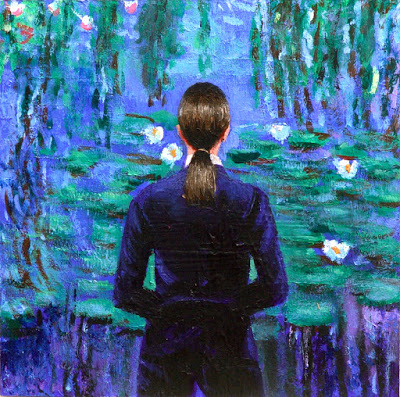

Exemplar based methods depend on large and diverse datasets of exemplars and relatively simple machine learning algorithms, such as Parzen window estimation and conditional random fields. They deliver impressive results on texture synthesis, image super resolution, and inpaiting, despite their simplicity. These techniques can accommodate web scale datasets with a improvement in sample quality as the dataset size increases, without the need for further optimization of model parameters. The success of exemplar based methods hinges on the distance metric used to build a local density model for each neighborhood. Further, while exemplar based methods excel in interpolation tasks, they often underperform their parametric counterparts in extrapolation.

Parametric generative models based on deep neural nets enable learning complex data distributions across myriad problem domain). Predominant models, such as Variational Autoencoders (VAEs), Normalizing Flows, and Generative Adversarial Networks (GANs), adopt a decoder network to convert samples from a prior distribution, often a factored Gaussian, into samples from the target distribution. After the completion of training, these models discard the training data and generate new samples using decoder networks alone. Hence, the burden of generative modeling rests entirely on the parametric model. Further, with the availability of additional training data, these models require re-training or fine-tuning.

Here we're going to talk about a probabilistic framework for exemplar based generative modeling using expressive neural nets. This framework combines the advantages of both exemplar based and parametric methods in a principled way and achieves superior results. We focus on simple unconditional generation tasks here, but the learning formulation and the methods developed are applicable to other applications including text to image translation and language modeling.

## What is an Exemplar Generative Model

We define an exemplar based generative model in terms of a dataset of $N$ exemplars, $X=\{x_n\}^N_{n=1}$, and a parametric transition distribution $T_\theta(x|x')$, which stochastically transforms an exemplar $x'$ into a new observation $x$. The log density of a data point $x$ under an exemplar based generative model $\{X,T_\theta\}$ is expressed as

$log p(x|X,\theta) = log \sum_{n=1}^N \frac{1}{N} T_\theta(x|x_n)$

where we assume the prior probability of selecting each exemplar is uniform. The transition distribution $T_\theta(x|x')$ can be defined using any expressive parametric generative model, including VAEs, Normalizing flow and auto-regressive models.



Exemplar VAE (XAE) is an instance of neural exemplar based generative models, in which the transition distribution in which $T(x|x')$ is defined in terms of the encoder $r_\phi$ and the decoder $p_\theta$ of a VAE

$T(x|x') = \int_z r_\phi(z|x')p_\theta(x|z) dz$

The XAE assumes that, given $z$, an observation $x$ is conditionally independent from the associated exemplar $x'$. This conditional independence assumption helps simplify the formulation, enabling efficient optimization. Marginalizing out the exemplar index $n$ and the latent variable $z$, we derive an evidence lower bound (ELBO) on XAE's log marginal likelihood for a single data point $x$ as:

$
log p(x;X,\theta,\phi)
$
$=log \sum_{n=1}^N \frac{1}{N}\int_z r_\phi(z|x_n)p_\theta(x|z)dz$
$=log \int_z p_\theta(x|z) \sum_{n=1}^N \frac{1}{N}r_\phi(z|x_n)dz$
$\geq \mathbb{E}_{q_\phi(z|x)} log p_\phi(x|z) - \mathbb{E}_{q_\phi(z|x)} log \frac{N q_\phi(z|x)}{\sum_{n=1}^N r_phi (z|x_n)}$


where $\mathbb{E}_{q_\phi(z|x)} log p_\phi(x|z)$ is the reconstruction and $\mathbb{E}_{q_\phi(z|x)} log \frac{N q_\phi(z|x)}{\sum_{n=1}^N r_phi (z|x_n)}$ the KL term.

The separation of the reconstruction and KL terms in summarizes the impact of the exemplars on the learning objective as a mixture prior distribution in the latent space, with each mixture component being defined using the latent encoding of one exemplar.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Cloning the Exemplar VAE repository

In [3]:
!git clone https://github.com/sajadn/Exemplar-VAE.git

Cloning into 'Exemplar-VAE'...
remote: Enumerating objects: 784, done.
remote: Total 784 (delta 0), reused 0 (delta 0), pack-reused 784
Receiving objects: 100% (784/784), 29.20 MiB | 26.11 MiB/s, done.
Resolving deltas: 100% (513/513), done.


In [4]:
!pip install torchvision
!pip install opencv-python
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=77ab743269ef1da5506820cf37bb565669e4f507a5d1f7dba1d9309327ef777a
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [5]:
!cd /content/Exemplar-VAE

In [8]:
!python /content/Exemplar-VAE/analysis.py --generate --dir /content/Exemplar-VAE/pretrained_model --tsne_visualization

Namespace(KNN=False, batch_size=100, classification_dir='classification_report', classify=False, count_active_dimensions=False, cyclic_generation=False, dir='/content/Exemplar-VAE/pretrained_model', epochs=100, generate=True, grid_interpolation=False, hidden_units=1024, hyper_lambda=0.4, input_size=[1, 28, 28], just_log_likelihood=False, lr=0.1, save_model_path='', seed=1, training_set_size=50000, tsne_visualization=True)
filename** 1
MODEL NAME vae
constructor
he initializer
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
data stats:
50000 50000
10000 10000
10000 10000
train size 50000
val size 10000
test size 10000
prior variance -2.418909788131714
references torch.Size([50, 78

# Attention Mechanisms and Transformers

Attention mechanisms relate data points within sequences. And they are very good at doing that.

Transformers use a specific type of attention mechanism, referred to as multi-head attention. This is the most important part of the model! Once you understand multi-head attention, it is pretty easy to understand Transformers as a whole. An illustration from the paper is shown below.

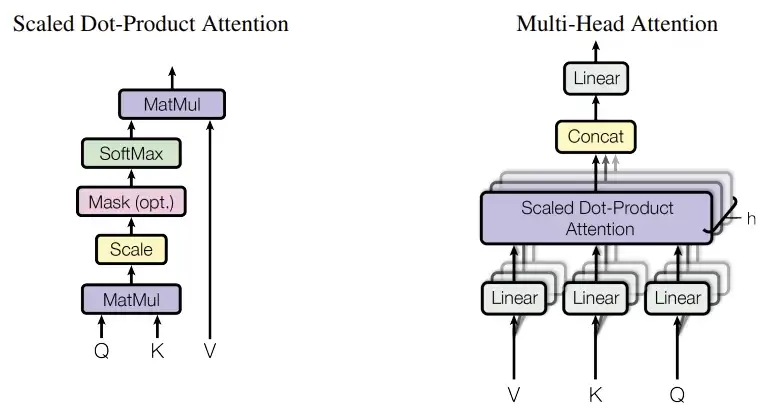

Let’s start with scaled dot-product attention, since we also need it to build the multi-head attention layer. Mathematically, it is expressed as:

$\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$

What exactly is happening here? Q, K, and V are batches of matrices, each with shape `(batch_size, seq_length, num_features)`. Multiplying the query (Q) and key (K) arrays results in a `(batch_size, seq_length, seq_length)` array, which tells us roughly how important each element in the sequence is. This is the attention of this layer — it determines which elements we “pay attention” to. The attention array is normalized using softmax, so that all of the weights sum to one. (Because we can’t pay more than 100% attention, right?) Finally, the attention is applied to the value (V) array using matrix multiplication.

Coding the scaled dot-product attention is pretty straightforward — just a few matrix multiplications, plus a softmax function. For added simplicity, we omit the optional **Mask** operation.

In [ ]:
from torch import Tensor
import torch.nn.functional as f


def scaled_dot_product_attention(query: Tensor, key: Tensor, value: Tensor) -> Tensor:
  temp = query.bmm(key.transpose(1, 2))
  scale = query.size(-1) ** 0.5
  softmax = f.softmax(temp / scale, dim=-1)
  return softmax.bmm(value)

Note that **MatMul** operations are translated to batch matrix-matrix multiplications `torch.bmm` in PyTorch. That’s because Q, K, and V (query, key, and value arrays) are batches of matrices, each with shape `(batch_size, sequence_length, num_features)`. Batch matrix multiplication is only performed over the last two dimensions.

From the diagram above, we see that multi-head attention is composed of several identical *attention* heads. Each attention head contains 3 linear layers, followed by scaled dot-product attention. Let’s encapsulate this in an `AttentionHead` layer:

In [ ]:
import torch
from torch import nn

class AttentionHead(nn.Module):

  def __init__(self, dim_in, dim_q, dim_k):
    super().__init__()
    self.q = nn.Linear(dim_in, dim_q)
    self.k = nn.Linear(dim_in, dim_k)
    self.v = nn.Linear(dim_in, dim_k)


  def forward(self, query, key, value):
    return scaled_dot_product_attention(self.q(query), self.k(key), self.v(value))

Now it's easy to build the multi-head attention layer. Just combine `num_heads` different attention heads and a `Linear` layer for the output.



In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self, num_heads, dim_in, dim_q, dim_k):
    super().__init__()
    self.heads = nn.ModuleList(
        [AttentionHead(dim_in, dim_q, dim_k) for _ in range(num_heads)]
    )

    self.linear = nn.Linear(num_heads*dim_k, dim_in)

  def forward(self, query, key, value):
    return self.linear(
        torch.cat([h(query, key, value) for h in self.heads], dim=-1)
    )

Let's examine what's going on in the `MultiHeadAttention` layer.

Each attention head computes its own *query*, *key*, and *value* arrays, and then applies scaled dot-product attention. Conceptually, this means each head can attend to a different part of the input sequence, independent of the others. 

Increasing the number of attention heads allows us to "pay attention" to more parts of the sequence at once, which makes the model more powerful.

## Positional Encoding

We need one more component before building the complete transformer: positional encoding. Notice that MultiHeadAttention has no trainable components that operate over the sequence dimension (axis 1). Everything operates over the feature dimension (axis 2), and so that it knows about the relative position of data points in the input sequences.

Vaswani et al. encode the positional information using trigonometric functions, according to the following equation:

$PE_{(pos, 2i)} = sin\bigg(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\bigg)$

$PE_{(pos, 2i+1)} = cos\bigg(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\bigg)$

In [ ]:
def position_encoding(seq_len, dim_model, device = torch.device('cpu')):
  pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1,-1,1)
  dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1,1,-1)
  phase = pos / (1e4 **(dim // dim_model))

  return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

In the equation above, there is a factor of two in the phase exponent, however it's applied at index $2i$ or $2i+1$ in the positional encoding. These factors of two should offset one another. 

**Why should we use such an unusual encoding? Surely, there are simpler choices!**

According to the authors:

"*We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results. We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.*"

**Why should sinusoidal encodings extrapolate to longer sequence lengths?**

Because sine/cosine functions are periodic, and they cover a range of $[0, 1]$. Most other choices of encoding would not be periodic or restricted to the range $[0, 1]$. Suppose that, during inference, you provide an input sequence longer than any used during training. Positional encoding for the last elements in the sequence could be different than anything the model has seen before. For those reasons, and despite the fact that learned embeddings appeared to perform equally as well, the authors still chose to use sinusoidal encoding.

## The Transformer

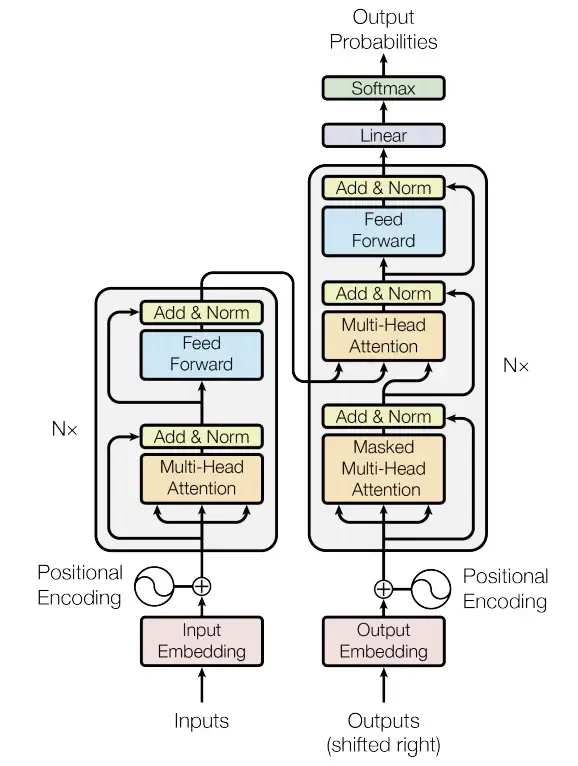

Notice that the transformer uses an encoder-decoder architecture. The encoder (left) processes the input sequence and returns a *feature vector* (or *memory* vector). The decoder processes the target sequence, and incorporates information from the encoder memory. The output from the decoder is our model’s prediction!

We can code the encoder/decoder modules independently of one another, and then combine them at the end. But first we need a few more pieces of information, which aren’t included in the figure above. For example, how should we choose to build the feed forward networks?

"*Each of the layers in our encoder and decoder contains a fully connected feed-forward network, which … consists of two linear transformations with a ReLU activation in between. The dimensionality of input and output is 512, and the inner-layer has dimensionality 2048."*

This gives a simple implementation for the **Feed Forward** modules above:

In [ ]:
def feed_forward(dim_input=512, dim_feedforward=2048):
  return nn.Sequential(
      nn.Linear(dim_input, dim_feedforward),
      nn.ReLU(),
      nn.Linear(dim_feedforward, dim_input)
  )

**What kind of normalization should be used? Do we need any regularization such as dropout layers?**

According to the authors:
*The output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer(x) is the function implemented by the sub-layer itself. … We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.*

We can encapsulate all of this in a Module:

In [ ]:
class Residual(nn.Module):
  
  def __init__(self, sublayer, dimension, dropout=0.1):
    super().__init__()
    self.sublayer = sublayer
    self.norm = nn.LayerNorm(dimension)
    self.dropout = nn.Dropout(dropout)

  def forward(self, *tensors):
    # Assuming that the "query" tensor is given first, we can compute
    # the residual. This matches the signture of "MultiHeadAttention"
    return self.norm(tensors[0] + self.dropout(self.sublayer(*tensors)))

### Encoder



In [ ]:
class TransformerEncoderLayer(nn.Module):
  
  def __init__(
      self,
      dim_model=512,
      num_heads=6,
      dim_feedforward=2048,
      dropout=0.1
  ):
  
    super().__init__()
    dim_q = dim_k = max(dim_model // num_heads, 1)
    self.attention = Residual(
        MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
        dimension=dim_model,
        dropout=dropout
    )

    self.feed_forward = Residual(
        feed_forward(dim_model, dim_feedforward),
        dimension=dim_model,
        dropout=dropout
    )
  
  def forward(self, src):
    src = self.attention(src, src, src)
    return self.feed_forward(src)


class TransformerEncoder(nn.Module):

  def __init__(
      self,
      num_layers=6,
      dim_model=512,
      num_heads=8,
      dim_feedforward=2048,
      dropout=0.1
  ):

    super().__init__()
    
    self.layers = nn.ModuleList(
        [
            TransformerEncoderLayer(dim_model, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ]
    )

  def forward(self, src):
    seq_len, dimension = src.size(1), src.size(2)
    src += position_encoding(seq_len, dimension)
    for layer in self.layers:
      src = layer(src)
    return src

### Decoder

The decoder module has the following differences w.r.t. the encoder:


*   The decoder accepts two arguments (*target* and *memory*) rather than one.
*   There are two multi-head attention modules per layer, instead of one.
*   The second multi-head attention accepts *memory* for two of its inputs.



In [ ]:
class TransformerDecoderLayer(nn.Module):

  def __init__(
      self,
      dim_model=512,
      num_heads=6,
      dim_feedforward=2048,
      dropout=0.1
  ):

    super().__init__()
    dim_q = dim_k = max(dim_model // num_heads, 1)

    self.attention_1 = Residual(
        MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
        dimension=dim_model,
        dropout=dropout
    )

    self.attention_2 = Residual(
        MultiHeadAttention(num_heads, dim_model, dim_q, dim_k),
        dimension=dim_model,
        dropout=dropout
    )

    self.feed_forward = Residual(
        feed_forward(dim_model, dim_feedforward),
        dimension=dim_model,
        dropout=dropout
    )

  def forward(self, target, memory):
    target = self.attention_1(target, target, target)
    target = self.attention_2(target, memory, memory)
    return self.feed_forward(target)


class TransformerDecoder(nn.Module):

  def __init__(
      self,
      num_layers=6,
      dim_model=512,
      num_heads=8,
      dim_feedforward=2048,
      dropout=0.1
  ):

    super().__init__()

    self.layers = nn.ModuleList(
        [
            TransformerDecoderLayer(dim_model, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ]
    )

    self.linear = nn.Linear(dim_model, dim_model)

  def forward(self, target, memory):
    seq_len, dimension = target.size(1), target.size(2)
    target += position_encoding(seq_len, dimension)

    for layer in self.layers:
      target = layer(target, memory)

    return torch.softmax(self.linear(target), dim=-1)

### Transformer class

In [ ]:
class Transformer(nn.Module):

  def __init__(
      self,
      num_encoder_layers=6,
      num_decoder_layers=6,
      dim_model=512,
      num_heads=6,
      dim_feedforward=2048,
      dropout=0.1,
      activation=nn.ReLU()
  ):

    super().__init__()
    self.encoder = TransformerEncoder(
        num_layers=num_encoder_layers,
        dim_model=dim_model,
        num_heads=num_heads,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    )

    self.decoder = TransformerDecoder(
        num_layers=num_decoder_layers,
        dim_model=dim_model,
        num_heads=num_heads,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    )

  def forward(self, src, target):
    return self.decoder(target, self.encoder(src))

### Simple test

We can construct random tensors for `src` and `target`, check that our model executes without errors, and confirm that the output tensor has the correct shape.

In [ ]:
src = torch.rand(64, 32, 512)
target = torch.rand(64, 16, 512)
out = Transformer()(src, target)

<ipython-input-4-320f3535debb>:4: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  phase = pos / (1e4 **(dim // dim_model))


torch.Size([64, 16, 512])


## Visual Transformer (ViT) and test on MNIST

Here we need to rely on Vision Transformers [1] which are a bit different than the one we wrote above.

[1] Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.

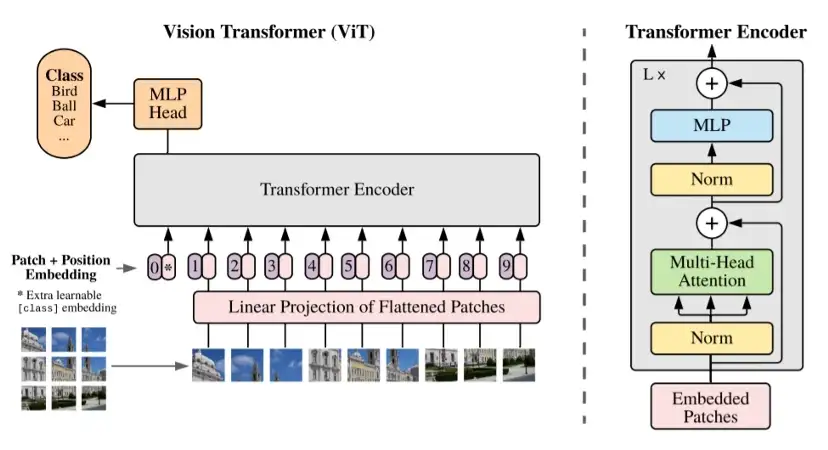

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 246 kB/s 


In [ ]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.norm = nn.LayerNorm(dim)
    self.fn = fn
  def forward(self, x, **kwargs):
    return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
  def __init__(self, dim, hidden_dim, dropout = 0.):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(dim, hidden_dim),
      nn.GELU(),
      nn.Dropout(dropout),
      nn.Linear(hidden_dim, dim),
      nn.Dropout(dropout)
    )
  def forward(self, x):
    return self.net(x)

class Attention(nn.Module):
  def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
    super().__init__()
    inner_dim = dim_head *  heads
    project_out = not (heads == 1 and dim_head == dim)

    self.heads = heads
    self.scale = dim_head ** -0.5

    self.attend = nn.Softmax(dim = -1)
    self.dropout = nn.Dropout(dropout)

    self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

    self.to_out = nn.Sequential(
      nn.Linear(inner_dim, dim),
      nn.Dropout(dropout)
    ) if project_out else nn.Identity()

  def forward(self, x):
    qkv = self.to_qkv(x).chunk(3, dim = -1)
    q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

    dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

    attn = self.attend(dots)
    attn = self.dropout(attn)

    out = torch.matmul(attn, v)
    out = rearrange(out, 'b h n d -> b n (h d)')
    return self.to_out(out)

class Transformer(nn.Module):
  def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
    super().__init__()
    print(mlp_dim)
    self.layers = nn.ModuleList([])
    for _ in range(depth):
      self.layers.append(nn.ModuleList([
          PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
          PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
      ]))
  def forward(self, x):
    for attn, ff in self.layers:
      x = attn(x) + x
      x = ff(x) + x
    return x

In [ ]:
class ViT(nn.Module):
  def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
    super().__init__()
    image_height, image_width = pair(image_size)
    patch_height, patch_width = pair(patch_size)

    assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

    num_patches = (image_height // patch_height) * (image_width // patch_width)
    patch_dim = channels * patch_height * patch_width
    assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

    self.to_patch_embedding = nn.Sequential(
      Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
      nn.Linear(patch_dim, dim),
    )

    self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
    self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
    self.dropout = nn.Dropout(emb_dropout)

    self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

    self.pool = pool
    self.to_latent = nn.Identity()

    self.mlp_head = nn.Sequential(
      nn.LayerNorm(dim),
      nn.Linear(dim, num_classes)
    )

  def forward(self, img):
    x = self.to_patch_embedding(img)
    b, n, _ = x.shape

    cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
    x = torch.cat((cls_tokens, x), dim=1)
    x += self.pos_embedding[:, :(n + 1)]
    x = self.dropout(x)

    x = self.transformer(x)

    x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

    x = self.to_latent(x)
    return self.mlp_head(x)

In [ ]:
import torch
import torchvision

torch.manual_seed(42)

DOWNLOAD_PATH = '/data/mnist'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

In [ ]:
def train_epoch(model, optimizer, data_loader, loss_history):
  total_samples = len(data_loader.dataset)
  model.train()

  for i, (data, target) in enumerate(data_loader):
    optimizer.zero_grad()
    output = F.log_softmax(model(data), dim=1)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
            ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
            '{:6.4f}'.format(loss.item()))
      loss_history.append(loss.item())

In [ ]:
def evaluate(model, data_loader, loss_history):
  model.eval()
  
  total_samples = len(data_loader.dataset)
  correct_samples = 0
  total_loss = 0

  with torch.no_grad():
    for data, target in data_loader:
      output = F.log_softmax(model(data), dim=1)
      loss = F.nll_loss(output, target, reduction='sum')
      _, pred = torch.max(output, dim=1)
      
      total_loss += loss.item()
      correct_samples += pred.eq(target).sum()

  avg_loss = total_loss / total_samples
  loss_history.append(avg_loss)
  print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
        '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
        '{:5}'.format(total_samples) + ' (' +
        '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

Here we define our Vision Transformer model with a patch size of 7x7 (which for a 28x28 image would mean 4 x 4 = 16 patches per image), 10 possible target classes (0 to 9), and 1 colour channel (since the images are grayscale).

In terms of the network parameters, we use an embedding dimension of 64 units, a depth of 6 Transformer blocks, 8 transformer heads, and 128 units in the hidden layer of the output MLP head. For the optimiser, we use Adam (as in the paper) with a learning rate of 0.003. We train our model for 25 epochs and look at the results.

There is no particular justification for using the hyperparameter values above. I just picked something that seemed reasonable. It is certainly possible that optimizing these would lead to higher accuracy and/or faster convergence.

In [ ]:
import time

N_EPOCHS = 25

start_time = time.time()
model = ViT(image_size=28, patch_size=7, num_classes=10,\
            dim=64, depth=6, heads=8, mlp_dim=128, channels=1)
optimizer = optim.Adam(model.parameters(), lr=0.003)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
  print('Epoch:', epoch)
  train_epoch(model, optimizer, train_loader, train_loss_history)
  evaluate(model, test_loader, test_loss_history)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

128
Epoch: 1
[    0/60000 (  0%)]  Loss: 2.4846
[10000/60000 ( 17%)]  Loss: 0.2261
[20000/60000 ( 33%)]  Loss: 0.1492
[30000/60000 ( 50%)]  Loss: 0.2806
[40000/60000 ( 67%)]  Loss: 0.1695
[50000/60000 ( 83%)]  Loss: 0.3395

Average test loss: 0.1611  Accuracy: 9487/10000 (94.87%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.2478
[10000/60000 ( 17%)]  Loss: 0.2280
[20000/60000 ( 33%)]  Loss: 0.1509
[30000/60000 ( 50%)]  Loss: 0.0910
[40000/60000 ( 67%)]  Loss: 0.1516
[50000/60000 ( 83%)]  Loss: 0.1778

Average test loss: 0.1122  Accuracy: 9675/10000 (96.75%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.0370
[10000/60000 ( 17%)]  Loss: 0.0807
[20000/60000 ( 33%)]  Loss: 0.0883
[30000/60000 ( 50%)]  Loss: 0.0961
[40000/60000 ( 67%)]  Loss: 0.0685
[50000/60000 ( 83%)]  Loss: 0.0919

Average test loss: 0.1125  Accuracy: 9652/10000 (96.52%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.0802
[10000/60000 ( 17%)]  Loss: 0.1210
[20000/60000 ( 33%)]  Loss: 0.1488
[30000/60000 ( 50%)]  Loss: 0.2207
[40000/60000 